In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
import random as rd
import matplotlib.pyplot as plt
import seaborn as snb
from sklearn import preprocessing, metrics
from sklearn.neural_network import MLPClassifier
import scipy.stats as st
from warnings import filterwarnings
import numpy as np
from scipy import stats

In [83]:
# Parâmetros utilizados no Gridsearchcv
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'solver': ['liblinear', 'newton-cholesky']
}

param_grid_deci_tree = {
    'criterion': ['gini', 'entropy', 'log_loss']
}

param_grid_knn = {
    'n_neighbors': [2,3,4,5,6,7,8,9,10, 20, 30, 40, 50],
    'metric': ['cityblock', 'euclidean', 'manhattan']
}

param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'gamma': ['scale', 'auto']
}

param_grid_random_forest = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [10, 100, 200, 300]
}

Vetores que vão armazenar as médias dos classificadores para o teste de Friedman

* Accurácia
* Sensibilidade
* Especificidade
* Taxa de falso positivo

In [84]:
def confidence_interval(values, p):
    mean = np.mean(values)
    std = np.std(values)
    return st.t.interval(alpha=p, df=len(values) - 1, loc=mean, scale=std)

def print_ic(low, high):
  if (high > 1.0):
    high = 1.0
  print("Intervalo de confiança p < 0.95 {} < x < {}".format(low,high))

In [85]:
def gridSearch(model, params, cv, X_train, y_train):
    grid = GridSearchCV(model, params, cv=cv)
    grid_results = grid.fit(X_train, y_train)
    print("Best Params")
    print(grid_results.best_params_)
    return grid_results.best_estimator_

In [86]:
def evaluate_model(model, X_train, y_train, cv, debug = False):
    list_specificity = []
    list_sensibility = []
    list_accuracy = []
    scores = cross_validate(model, X_train, y_train, scoring='accuracy', cv = cv, n_jobs=-1, return_estimator=True)
    estimators = scores['estimator']
    
    if (debug):
        for i, (train_index, test_index) in enumerate(cv.split(X_train)):
    
            X_pred = X_train[test_index]
            y_ground = y_train[test_index]
            y_pred = estimators[0].predict(X_pred)
            tn, fp, fn, tp = confusion_matrix(y_ground, y_pred).ravel()
            sensibility = tp / (tp + fn)
            specificity = tn / (tn + fp)
            accuracy = (tp+tn)/(tp+tn+fp+fn)
            list_sensibility.append(sensibility)
            list_specificity.append(specificity)
            list_accuracy.append(accuracy)
    
            print(f"Fold {i}")
            print(f'Number of samples: {len(X_pred)}')
            print(f"Mean Specificity= {specificity}")
            print(f"Mean Sensibility= {sensibility}\n\n")
  
            ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_ground, y_pred), display_labels=['Non Infart', 'Infart']).plot()
            plt.grid(False)
            plt.show()
    
        print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
        print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
        print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
    return scores

In [87]:
def show_roc_curve(classifier, y_true, X):
    y_pred = classifier.predict(X)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auc = roc_auc_score(y_true, y_pred)
    RocCurveDisplay.from_predictions(y_true, y_pred, pos_label=1)
    return (fpr, tpr, thresholds, auc)

In [88]:
def print_metrics_mean(list_accuracy, list_sensibility, list_specificity, list_false_positive_rate):
    print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
    lower, higher = confidence_interval(list_specificity, 0.95)
    print_ic(lower, higher)
    print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
    lower, higher = confidence_interval(list_sensibility, 0.95)
    print_ic(lower, higher)
    print(f"Mean Accuracy = {np.mean(list_accuracy)} Sdt: {np.std(list_accuracy)}")
    lower, higher = confidence_interval(list_accuracy, 0.95)
    print_ic(lower, higher)
    print(f"Mean False Positive Rate = {np.mean(list_false_positive_rate)} Sdt: {np.std(list_false_positive_rate)}")
    lower, higher = confidence_interval(list_false_positive_rate, 0.95)
    print_ic(lower, higher)

In [89]:
def evaluate_kfold(list_of_estimators, X_total, y_total):
    # Verificando a media com todos os elementos e classificadores
    list_sensibility = []
    list_specificity = []
    list_false_positive_rate = []
    list_accuracy = []
    X_pred = X_total
    y_truth = y_total
    
    for i, estimator in enumerate(list_of_estimators):
  
        y_pred = estimator.predict(X_pred)
        tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
        sensibility = tp / (tp + fn)
        specificity = tn / (tn + fp)
        sensibility = tp / (tp + fn)
        false_positive_rate = 1 - specificity
        accuracy = (tp+tn)/(tp+tn+fp+fn)
       
        print(f'Estimator {i}')
        print(f"Accuracy = {accuracy}")
        print(f"Specificity = {specificity}")
        print(f"Sensibility = {sensibility}")
        print(f'False Positive rate: {false_positive_rate}')
        
        # Appending Lists
        list_sensibility.append(sensibility)
        list_specificity.append(specificity)
        list_false_positive_rate.append(false_positive_rate)
        list_accuracy.append(accuracy)
        
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Non Infart', 'Infart']).plot()
        show_roc_curve(estimator, y_truth, X_total)
        plt.grid(False)
        plt.show()

    print_metrics_mean(list_accuracy, list_sensibility, list_specificity, list_false_positive_rate)
    return (list_accuracy, list_sensibility, list_specificity, list_false_positive_rate)


In [90]:
def print_metrics(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensibility = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensibility = tp / (tp + fn)
    false_positive_rate = 1 - specificity
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    
    print("--"*20)
    print(f"Accuracy = {accuracy}")
    print(f"Specificity = {specificity}")
    print(f"Sensibility = {sensibility}")
    print(f'False Positive rate: {false_positive_rate}')
    print("--"*20)

In [91]:
def evaluate_estimator(classifier, x, y):
    y_pred = classifier.predict(x)
    print_metrics(y, y_pred)
   

In [92]:
def get_best_classifier(scores):
    return scores['estimator'][np.argmax(scores['test_score'])]

In [93]:
# Seed
seed = 123456

In [94]:
# For windows
df = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\src\\complete_dataset.csv', index_col=0)
comertial_test_1 = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\src\\comertial_virgin.csv', index_col=0)
comertial_test_2 = pd.read_csv('C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\src\\comertial_rodamine.csv', index_col=0)
#polimid_test_1 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/polimid_virgin.csv', index_col=0)
#polimid_test_2 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/polimid_rodamine.csv', index_col=0)
test_df = pd.concat([comertial_test_2], axis=0, ignore_index=True)
#test_df = pd.concat([comertial_test_1, comertial_test_2], axis=0, ignore_index=True)
test_df['target'] = np.zeros(shape=(test_df.shape[0],), dtype=int)

In [18]:
df = pd.read_csv('../data/complete_dataset.csv', index_col=0)
comertial_test_1 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/comertial_virgin.csv', index_col=0)
comertial_test_2 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/comertial_rodamine.csv', index_col=0)
polimid_test_1 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/polimid_virgin.csv', index_col=0)
polimid_test_2 = pd.read_csv('/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/polimid_rodamine.csv', index_col=0)
test_df = pd.concat([comertial_test_1, comertial_test_2, polimid_test_1, polimid_test_2], axis=0, ignore_index=True)
#test_df = pd.concat([comertial_test_1, comertial_test_2], axis=0, ignore_index=True)
test_df['target'] = np.zeros(shape=(test_df.shape[0],), dtype=int)

FileNotFoundError: [Errno 2] No such file or directory: '/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/src/comertial_virgin.csv'

In [95]:
df.head()

,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
0,111.206245,-128.070497,582.026580,239.276743,0.205634,84.763748,-89.000926,1
1,117.477703,-132.831311,554.636573,250.309014,0.199645,88.426733,-92.060480,1
2,111.984444,-133.417261,636.900253,245.401704,0.193656,87.221721,-93.731053,1
3,114.831800,-148.762000,497.157678,263.593800,0.187666,96.151949,-108.130415,1
4,100.741600,-122.019000,609.328195,222.760600,0.183673,83.015207,-90.556571,1


In [96]:
df.tail()

,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
50,93.579555,-142.099047,703.929038,235.678601,0.192003,77.378071,-99.576142,0
51,0.000000,-129.023850,629.446398,0.000000,0.000000,65.455168,-90.572485,0
52,107.623529,-130.686378,546.450781,238.309908,0.188003,82.729708,-88.611173,0
53,85.166931,-104.910982,686.594488,190.077913,0.188003,67.804083,-74.661710,0
54,85.041928,-109.342301,665.782497,194.384229,0.192003,64.283984,-73.564895,0


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   corrente_anodica                55 non-null     float64
 1   corrente_catodica               55 non-null     float64
 2   carga                           55 non-null     float64
 3   diff_corrente_anodica_catodica  55 non-null     float64
 4   diff_pot_anodico_catodico       55 non-null     float64
 5   pico_derivada_anodica           55 non-null     float64
 6   pico_derivada_catodica          55 non-null     float64
 7   target                          55 non-null     int64  
dtypes: float64(7), int64(1)
memory usage: 3.9 KB


In [98]:
test_df.head()

,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
0,176.393000,-189.247000,-114.565458,365.640000,0.201642,101.236170,-107.573334,0
1,175.431000,-186.958000,-113.992818,362.389000,0.217613,96.305632,-101.711570,0
2,177.592000,-189.302000,-106.740656,366.894000,0.201642,101.749602,-108.220582,0
3,174.269000,-184.807000,-99.399534,359.076000,0.223602,94.149523,-99.027024,0
4,176.530075,-191.627371,-114.156399,368.157446,0.223602,94.446169,-100.431722,0


In [99]:
test_df.tail()

,corrente_anodica,corrente_catodica,carga,diff_corrente_anodica_catodica,diff_pot_anodico_catodico,pico_derivada_anodica,pico_derivada_catodica,target
13,175.193405,-189.787138,-120.584531,364.980543,0.221605,94.165588,-100.279198,0
14,178.608370,-196.269167,-120.602566,374.877536,0.219610,96.479549,-104.161789,0
15,179.954243,-194.905007,-125.054280,374.859250,0.209628,101.477203,-108.230276,0
16,184.412909,-201.304650,-122.742109,385.717559,0.189662,108.971388,-117.646975,0
17,177.225923,-189.594877,-119.704565,366.820800,0.217613,98.378412,-103.754059,0


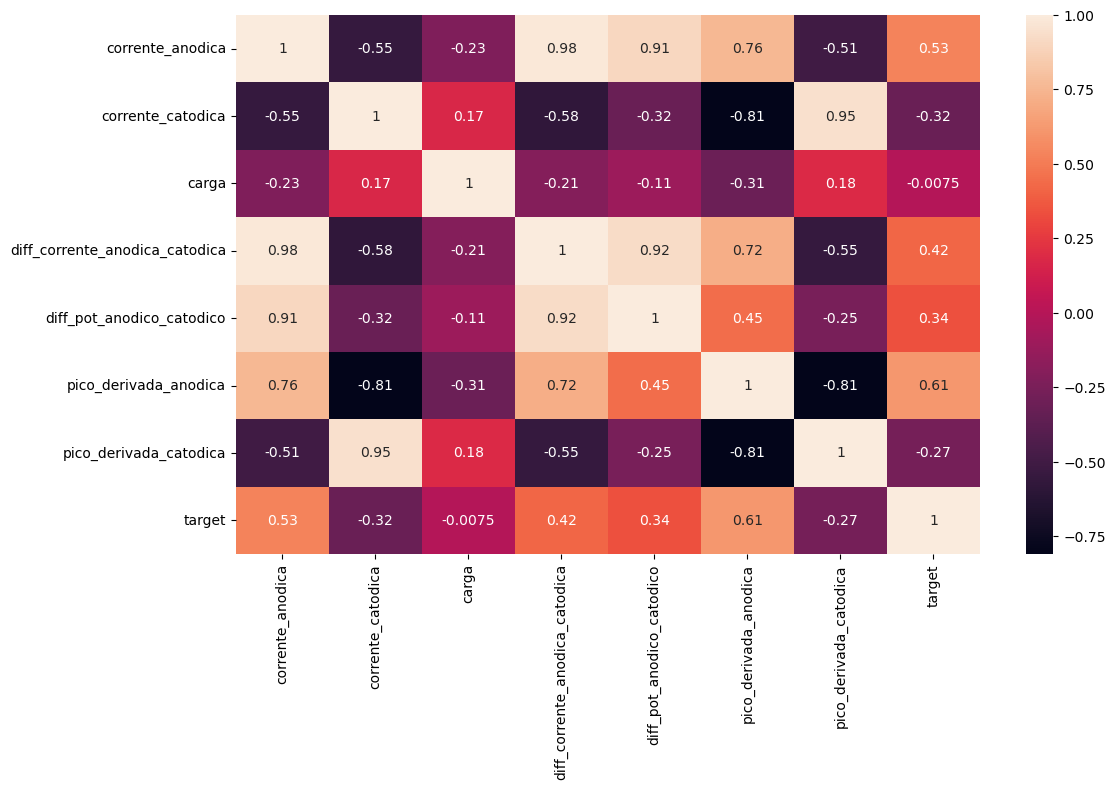

In [100]:
fig, ax = plt.subplots(figsize=(12,7))
ax = snb.heatmap(df.iloc[:,:].corr(), annot=True)
plt.show()

# Experimento apenas com menos features

Como algumas features são bem relacionadas umas com as outras eu vou pegar apenas:\\
* 1 - Pico da derivada anódica
* 2 - Diferença potencial anódico e catódico
* 3 - Diferença entre corrente anódica e catódica

In [101]:
# Preparando os dados
X_less_features = df.loc[:,['pico_derivada_anodica', 'diff_pot_anodico_catodico', 'diff_corrente_anodica_catodica', 'corrente_anodica', 'pico_derivada_catodica']]
#X.drop(['carga'], axis=1)
y = df['target']
y_test = test_df['target']
X_test_less_features = test_df.loc[:,['pico_derivada_anodica', 'diff_pot_anodico_catodico', 'diff_corrente_anodica_catodica', 'corrente_anodica', 'pico_derivada_catodica']]

scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X_less_features.values)
X_train = scaler.transform(X_less_features.values)
X_test = scaler.transform(X_test_less_features.values)
cv = StratifiedKFold(n_splits = 10, random_state=seed, shuffle=True)

In [102]:
# Preparando os dados
X = df.iloc[:,:-1]
X.drop('carga', axis=1, inplace=True)
x_sanity = test_df.iloc[:,:-1]
x_sanity.drop('carga', axis=1, inplace=True)
y_sanity = test_df['target'].values
y = df['target']
(x_train, x_test, y_train, y_test) = train_test_split(X.values, y.values, test_size=0.3, random_state=seed)
#y_test = test_df['target']
#X_test = test_df.iloc[:,:-1].drop(['carga'], axis=1)

scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X.values)
#X_train = scaler.transform(X.values)
#X_test = scaler.transform(X_test.values)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_sanity = scaler.transform(x_sanity.values)
x_total = np.concatenate([x_train, x_test], axis=0)
y_total = np.concatenate([y_train, y_test], axis=0)
#cv = KFold(n_splits = 5, random_state=seed, shuffle=True)

In [103]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)
print(x_total.shape)
print(y_total.shape)
print(x_sanity.shape)
print(y_sanity.shape)

(17, 6)
(17,)
(38, 6)
(38,)
(55, 6)
(55,)
(18, 6)
(18,)


In [104]:

print(x_train.mean())
print(x_train.std())
print(x_test.mean())
print(x_test.std())
print(x_sanity.mean())
print(x_sanity.std())

0.01845075280860742
0.9473766068748808
-0.04124285921924072
1.1075222627247305
0.4062920165452077
3.241650449365789


## Logistic Regression

c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
350 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in

Best Params
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Estimator 0
Accuracy = 0.8545454545454545
Specificity = 0.8620689655172413
Sensibility = 0.8461538461538461
False Positive rate: 0.13793103448275867


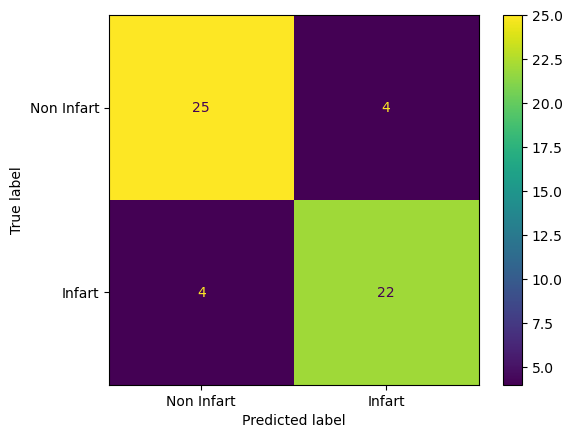

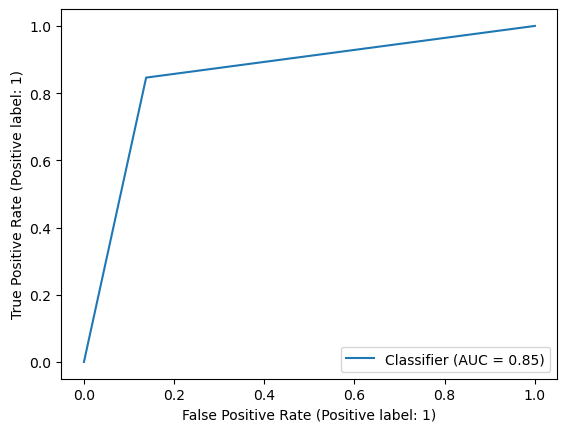

Estimator 1
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


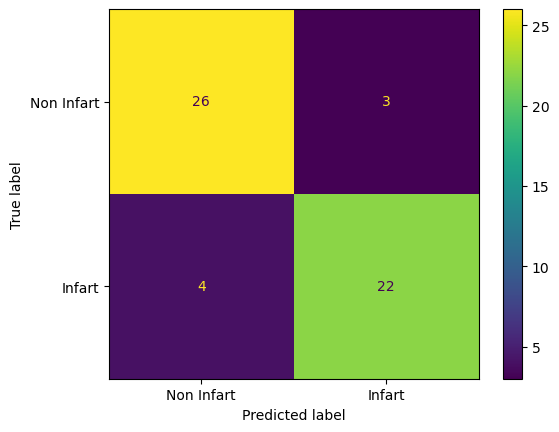

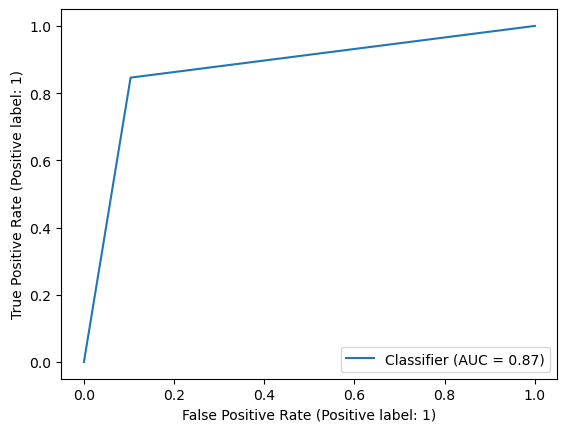

Estimator 2
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


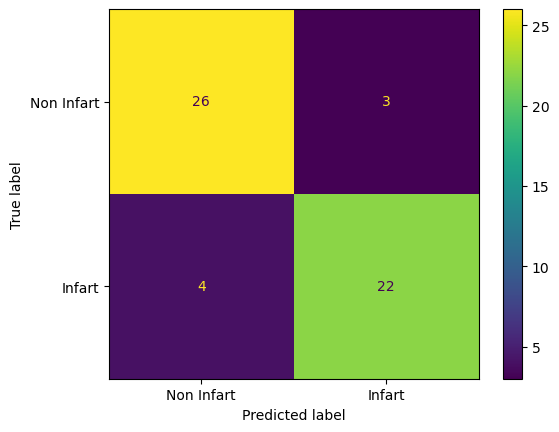

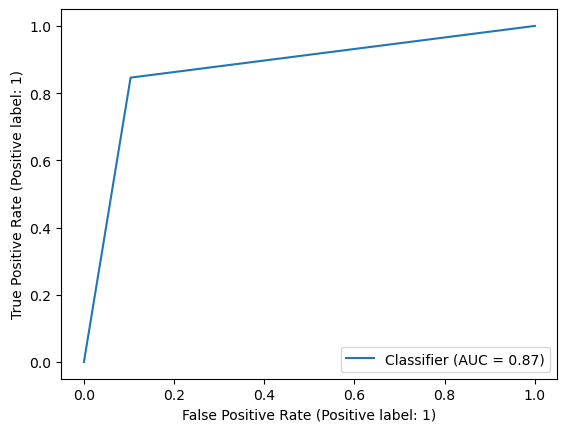

Estimator 3
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


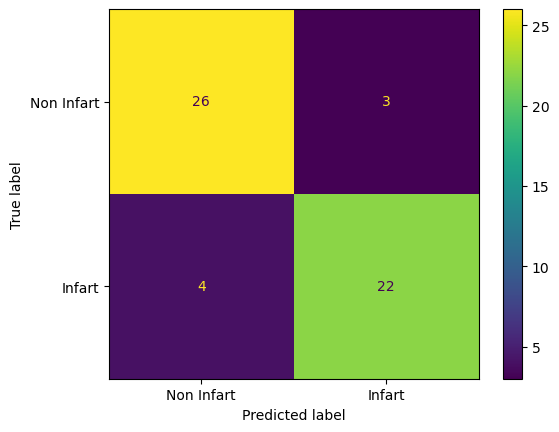

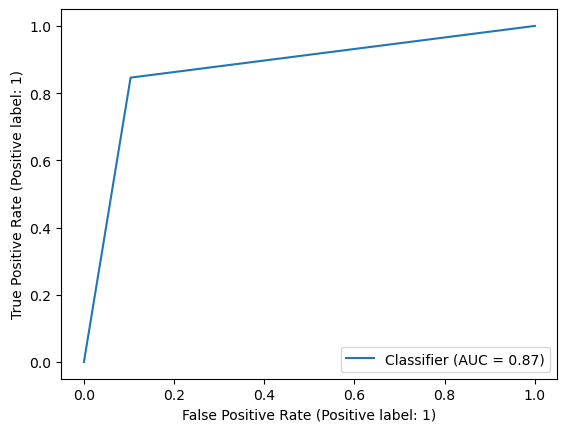

Estimator 4
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


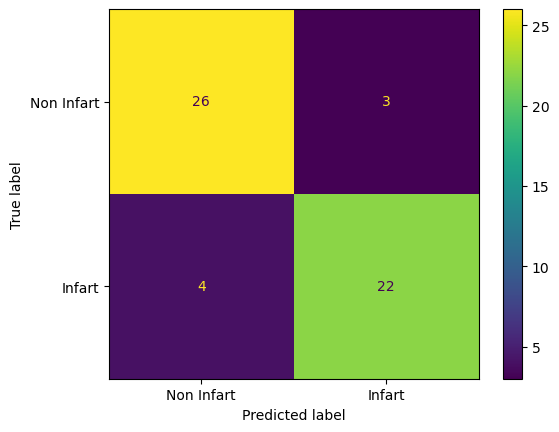

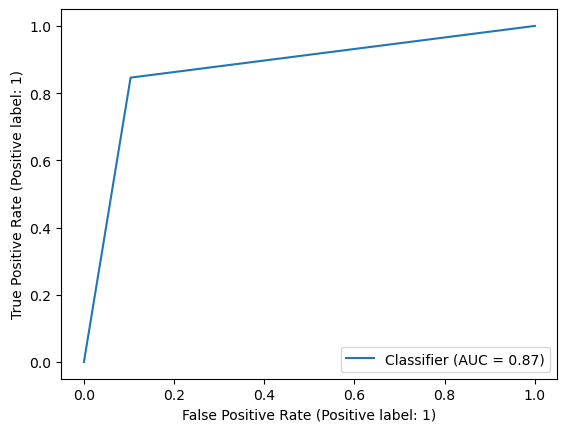

Estimator 5
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


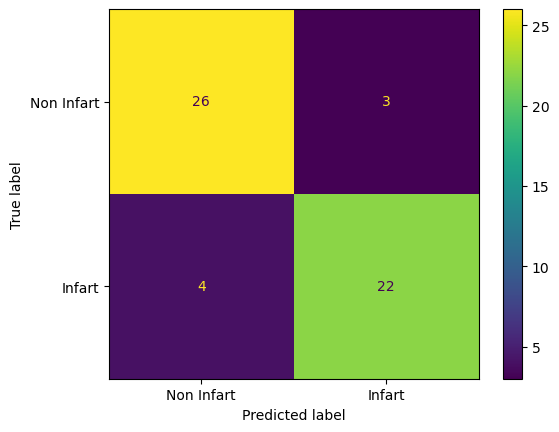

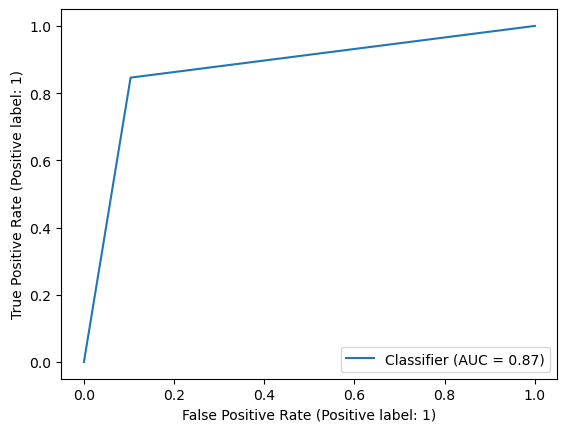

Estimator 6
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


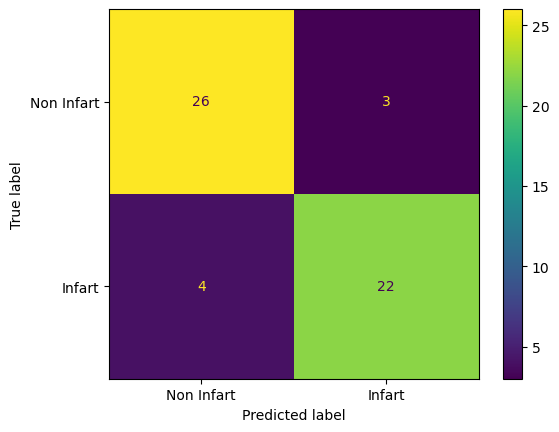

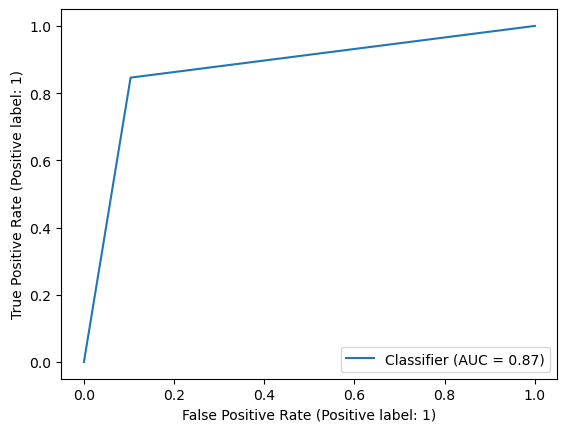

Estimator 7
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


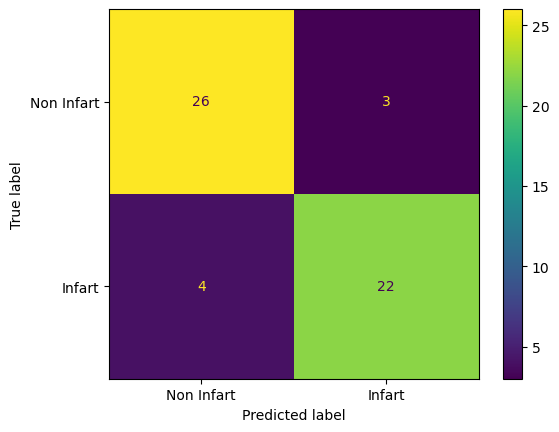

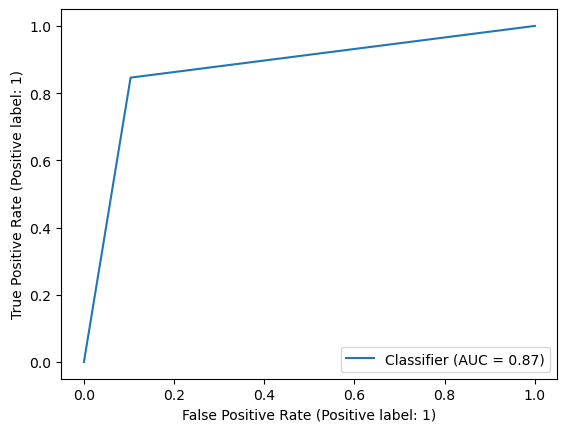

Estimator 8
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


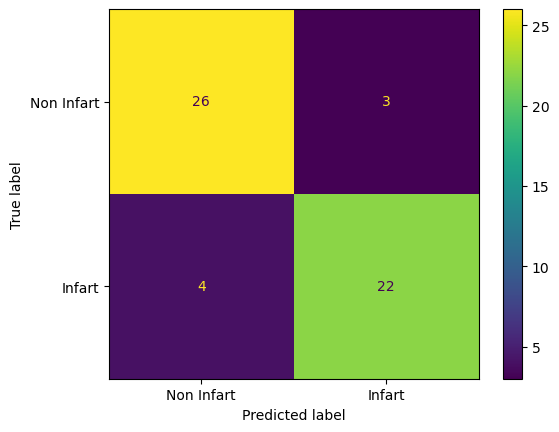

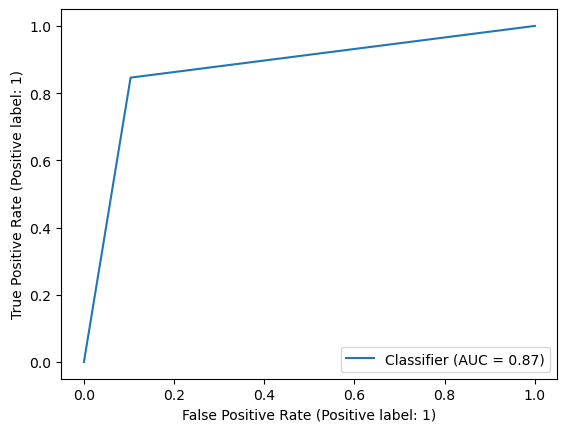

Estimator 9
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895


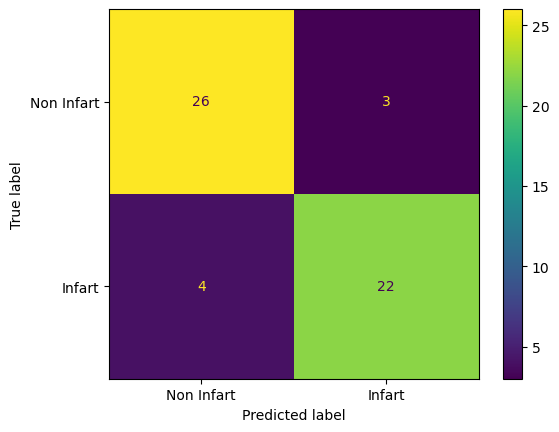

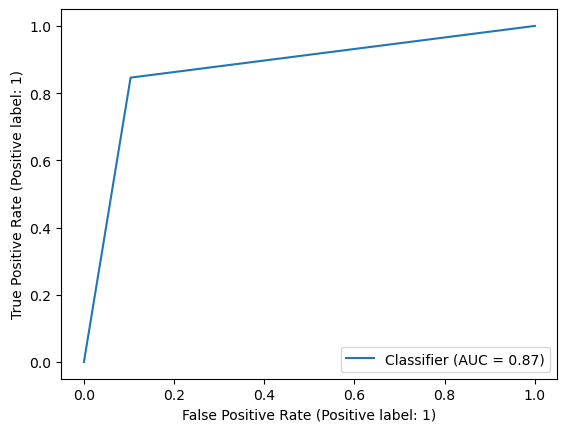

Mean Specificity= 0.8931034482758621 Std: 0.010344827586206915
Intervalo de confiança p < 0.95 0.8697018224544035 < x < 0.9165050740973206
Mean Sensibility= 0.8461538461538461  Std: 0.0
Intervalo de confiança p < 0.95 nan < x < nan
Mean Accuracy = 0.8709090909090909 Sdt: 0.005454545454545456
Intervalo de confiança p < 0.95 0.8585700518395946 < x < 0.8832481299785871
Mean False Positive Rate = 0.10689655172413792 Sdt: 0.010344827586206915
Intervalo de confiança p < 0.95 0.08349492590267935 < x < 0.1302981775455965


c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [105]:
model = LogisticRegression(max_iter=1000, random_state=seed)
model = gridSearch(model, param_grid_logistic, cv, x_train, y_train)
scores_logistic = evaluate_model(model, x_train, y_train, cv)
logistic_best = get_best_classifier(scores_logistic)
estimators_logistic = scores_logistic['estimator']
(list_accuracy_logistic, list_sensibility_logistic, list_specificity_logistic, list_false_positive_rate_logistic) = evaluate_kfold(estimators_logistic, x_total, y_total)

In [54]:
# # Verificando a media com todos os elementos e classificadores da regressão logística
# list_sensibility_logistic = []
# list_specificity_logistic = []
# list_false_positive_rate_logistic = []
# list_accuracy_logistic = []

# for i, estimator in enumerate(scores['estimator']):
#     print(f'Estimator {i}\n\n')
#     X_pred = x_total
#     y_truth = y_total
#     y_pred = estimator.predict(X_pred)
#     tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
#     sensibility = tp / (tp + fn)
#     specificity = tn / (tn + fp)
#     false_positive_rate = 1 - specificity
#     accuracy = (tp+tn)/(tp+tn+fp+fn)
#     print(f'Number of samples: {len(X_pred)}')
#     print(f"Accuracy = {accuracy}")
#     print(f"Specificity= {specificity}")
#     print(f"Sensibility= {sensibility}")
#     print(f'False Positive rate: {false_positive_rate}\n\n')
#     list_sensibility_logistic.append(sensibility)
#     list_specificity_logistic.append(specificity)
#     list_accuracy_logistic.append(accuracy)
  
#     ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Non Infart', 'Infart']).plot()
#     show_roc_curve(estimator, y_truth, X_pred)
#     plt.grid(False)
#     plt.show()

# print(f"Mean Specificity= {np.mean(list_specificity_logistic)} Std: {np.std(list_specificity_logistic)}")
# print(f"Mean Sensibility= {np.mean(list_sensibility_logistic)}  Std: {np.std(list_sensibility_logistic)}")
# print(f"Mean Accuracy = {np.mean(list_accuracy_logistic)} Sdt: {np.std(list_accuracy_logistic)}")

In [106]:
def marjoritary_vote(estimators, x_values):
    pred_list = np.zeros(shape=(len(estimators), x_values.shape[0]), dtype=int)
    predictions = np.zeros(shape=(x_values.shape[0],), dtype=int)
    
    for i in range(len(estimators)):
        pred_list[i] = estimators[i].predict(x_values)
    
    
    for j in range(pred_list.shape[1]):
        vote_0 = 0
        vote_1 = 0
        for i in range(pred_list.shape[0]):
            vote = pred_list[i,j]
            if (vote == 0):
                vote_0 += 1
            else:
                vote_1 += 1
        if (vote_1 > vote_0):
            predictions[j] = 1
    return predictions
        

def majoritary_voting_pred(estimators, X_test):
    
    pred_list = []
    
    for i in range(X_test.shape[0]):
        sum_0 = 0
        sum_1 = 0
    
        for est in estimators:
            pred = est.predict(X_test[i])
        
            if (pred == 0):
                sum_0 += 1
            else:
                sum_1 = 1
    
        if sum_1 > sum_0:
            pred_list.append(1)
        else:
            pred_list.append(0)
        
    return pred_list

def calc_accuracy(y_truth, y_pred):

    assert len(y_truth) == len(y_pred)
    
    n_of_right = 0
     
    for i in range(len(y_pred)):
        if y_truth[i] == y_pred[i]:
            n_of_right += 1
    
    return (n_of_right / len(y_truth)) * 1.0
        

In [56]:
# best_logistic_regression = scores['estimator'][np.argmax(scores['test_score'])]

In [107]:
# Avaliando o melhor estimador da regressão logística com todo o conjunto
evaluate_estimator(logistic_best, x_total, y_total)

----------------------------------------
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895
----------------------------------------


In [108]:
evaluate_estimator(logistic_best, x_test, y_test)

----------------------------------------
Accuracy = 0.8823529411764706
Specificity = 1.0
Sensibility = 0.75
False Positive rate: 0.0
----------------------------------------


In [111]:
logistic_best.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [112]:
# Utilizando um conjunto de amostras de eletrodo comercial apenas modificadas e não modificadas com Rodamina
estimators = scores_logistic['estimator']
pred = marjoritary_vote(estimators, x_total)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.8727272727272727
Specificity = 0.896551724137931
Sensibility = 0.8461538461538461
False Positive rate: 0.10344827586206895
----------------------------------------


## KNN

c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\metrics\_scorer.py", line 430, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\base.py", line 638, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "c:\Users\pves\anaconda3\envs\edapy\lib\site-packages\

Best Params
{'metric': 'euclidean', 'n_neighbors': 10}
Estimator 0
Accuracy = 0.8181818181818182
Specificity = 0.896551724137931
Sensibility = 0.7307692307692307
False Positive rate: 0.10344827586206895


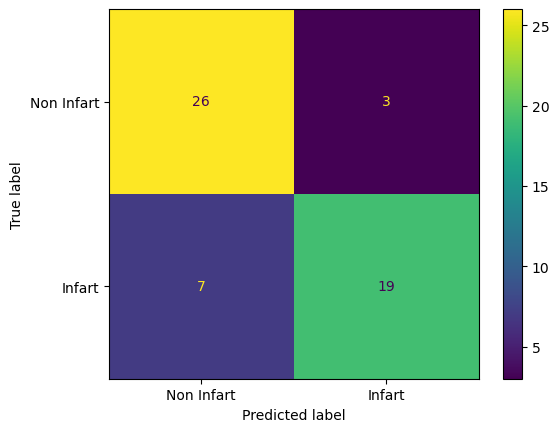

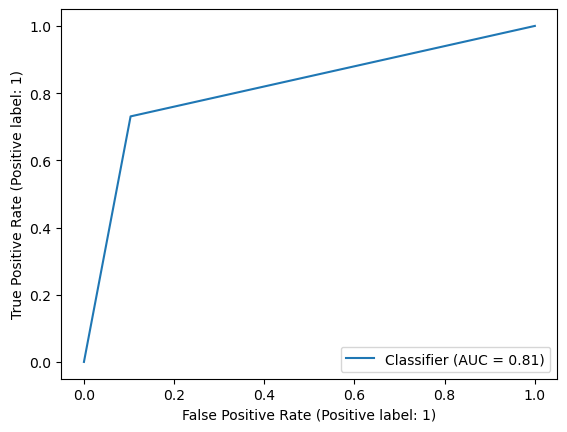

Estimator 1
Accuracy = 0.8181818181818182
Specificity = 0.896551724137931
Sensibility = 0.7307692307692307
False Positive rate: 0.10344827586206895


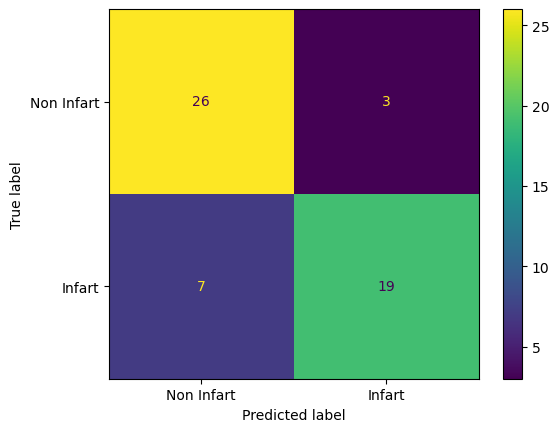

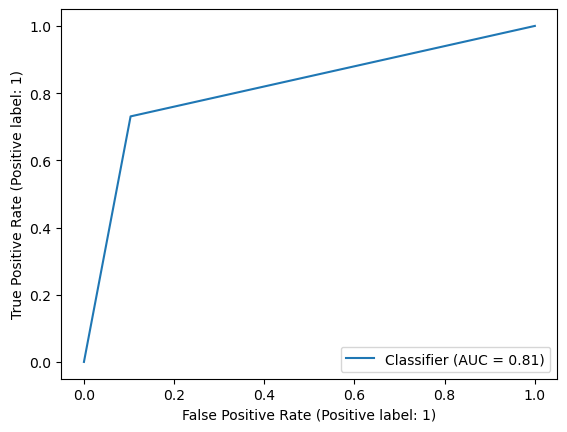

Estimator 2
Accuracy = 0.8363636363636363
Specificity = 0.9310344827586207
Sensibility = 0.7307692307692307
False Positive rate: 0.06896551724137934


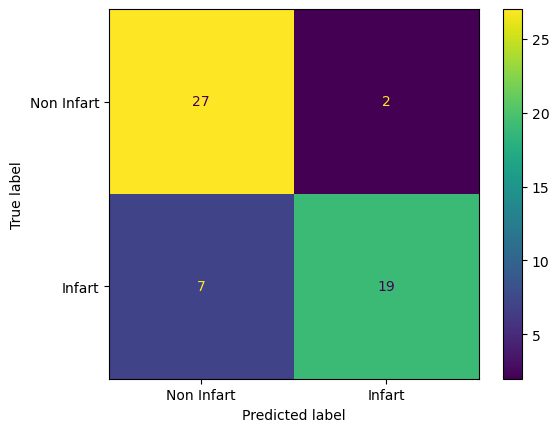

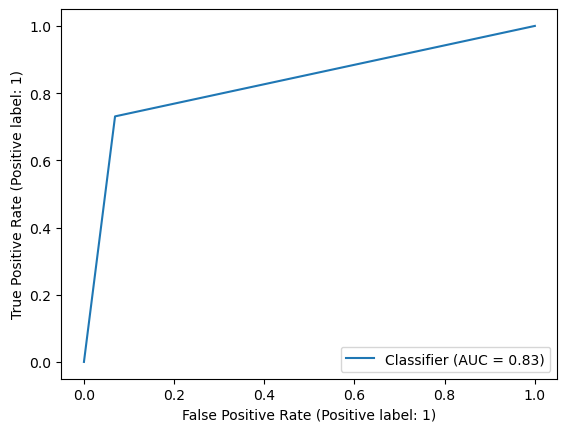

Estimator 3
Accuracy = 0.8363636363636363
Specificity = 0.9310344827586207
Sensibility = 0.7307692307692307
False Positive rate: 0.06896551724137934


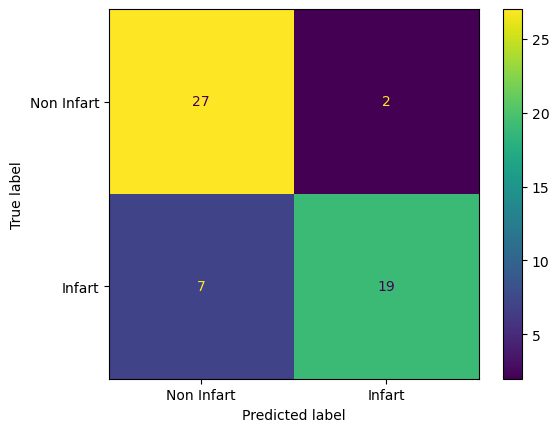

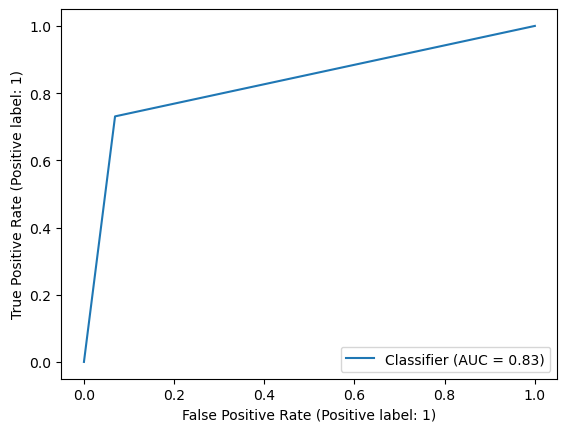

Estimator 4
Accuracy = 0.8181818181818182
Specificity = 0.896551724137931
Sensibility = 0.7307692307692307
False Positive rate: 0.10344827586206895


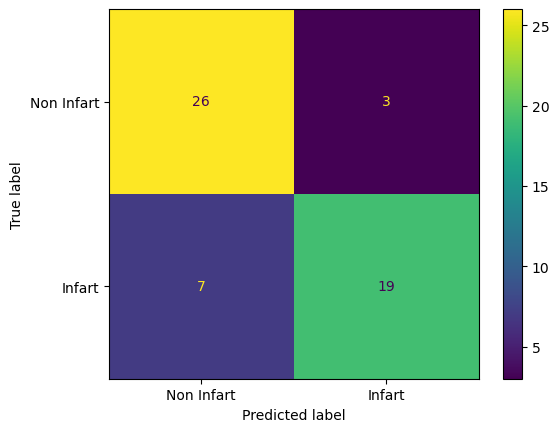

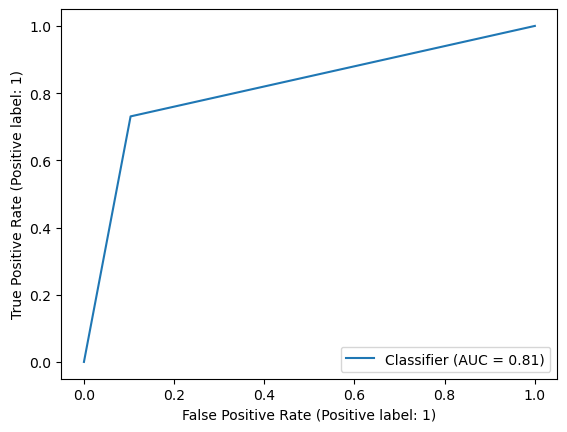

Estimator 5
Accuracy = 0.8181818181818182
Specificity = 0.9310344827586207
Sensibility = 0.6923076923076923
False Positive rate: 0.06896551724137934


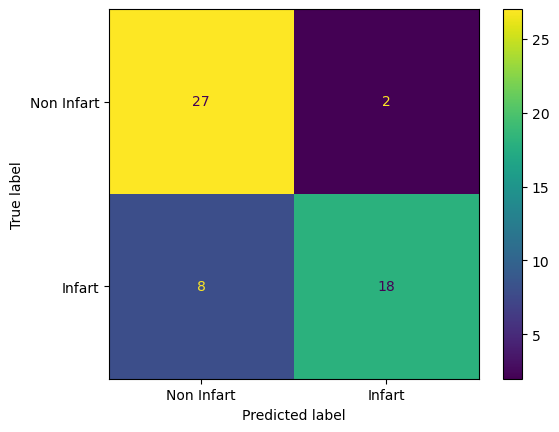

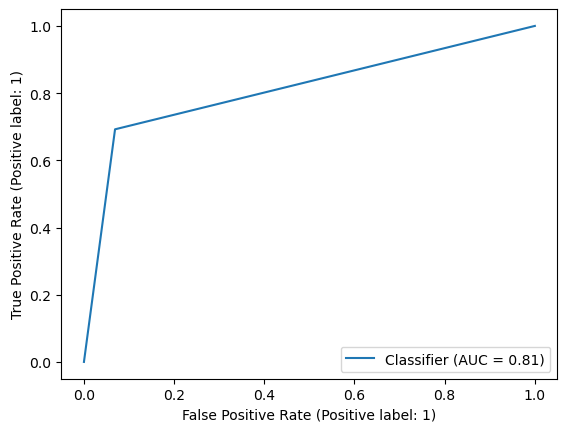

Estimator 6
Accuracy = 0.8363636363636363
Specificity = 0.9310344827586207
Sensibility = 0.7307692307692307
False Positive rate: 0.06896551724137934


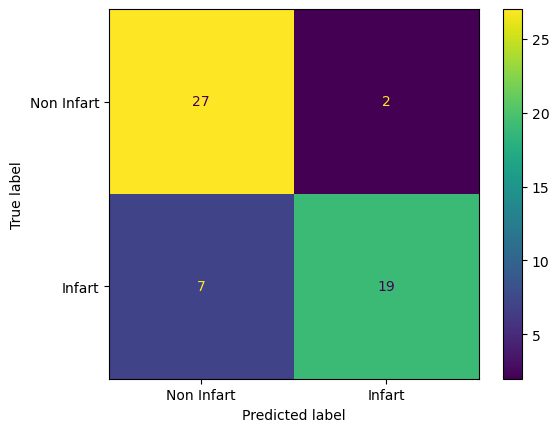

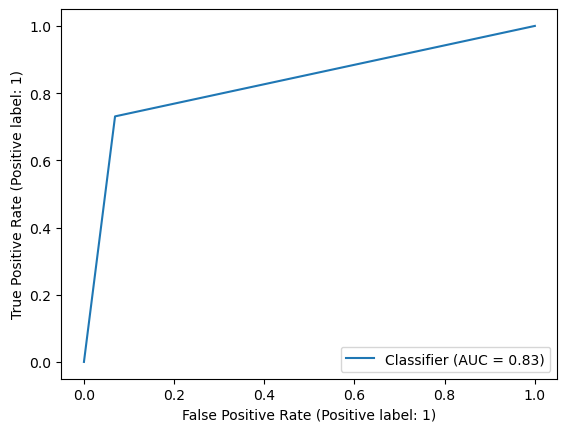

Estimator 7
Accuracy = 0.8363636363636363
Specificity = 0.9310344827586207
Sensibility = 0.7307692307692307
False Positive rate: 0.06896551724137934


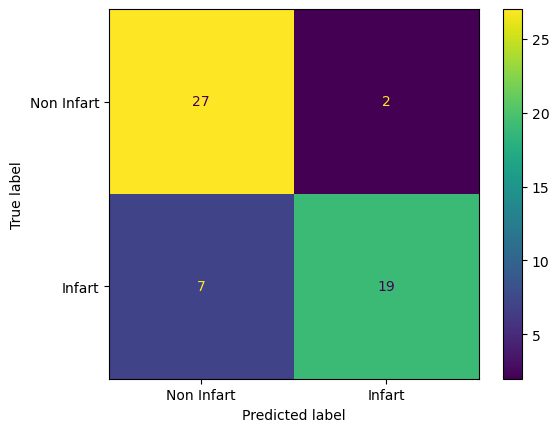

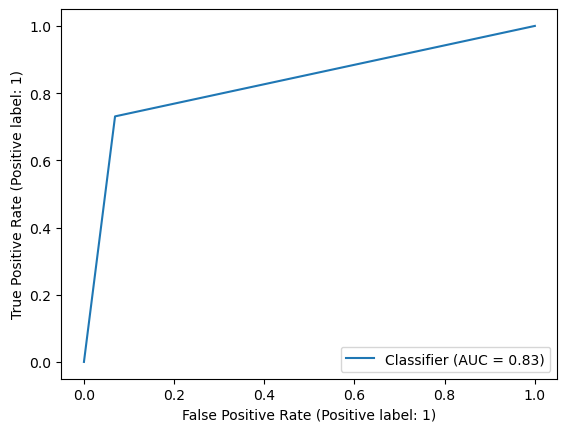

Estimator 8
Accuracy = 0.8363636363636363
Specificity = 0.9310344827586207
Sensibility = 0.7307692307692307
False Positive rate: 0.06896551724137934


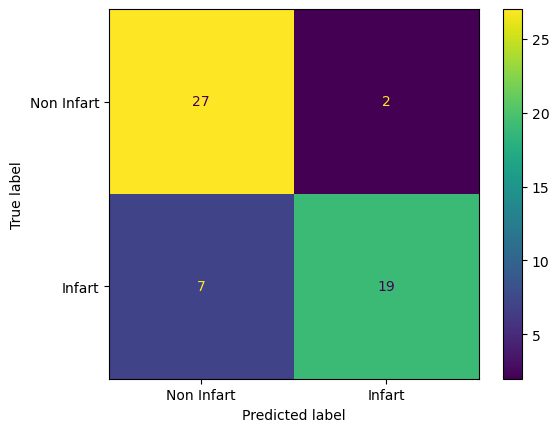

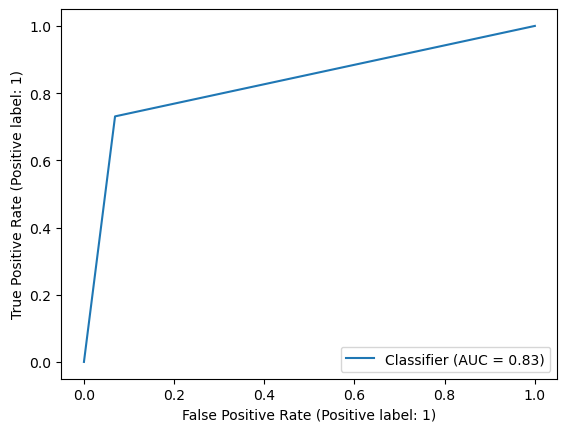

Estimator 9
Accuracy = 0.8363636363636363
Specificity = 0.9310344827586207
Sensibility = 0.7307692307692307
False Positive rate: 0.06896551724137934


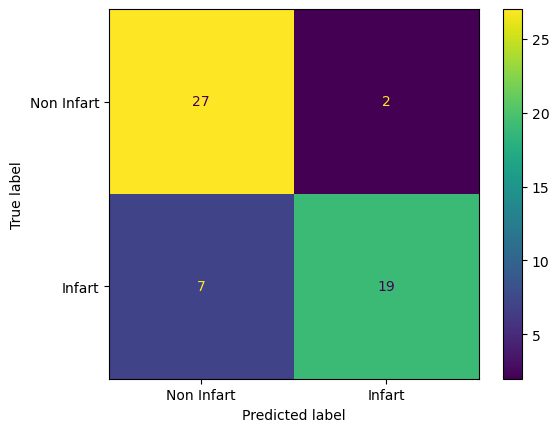

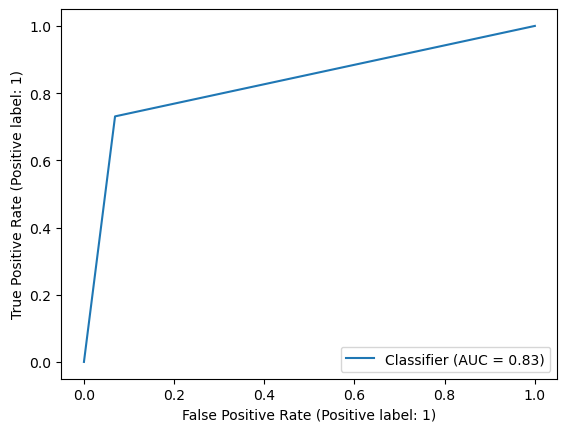

Mean Specificity= 0.9206896551724137 Std: 0.01580198515502012
Intervalo de confiança p < 0.95 0.8849430812684582 < x < 0.9564362290763693
Mean Sensibility= 0.7269230769230768  Std: 0.011538461538461532
Intervalo de confiança p < 0.95 0.7008212635068346 < x < 0.753024890339319
Mean Accuracy = 0.8290909090909091 Sdt: 0.008907235428302416
Intervalo de confiança p < 0.95 0.8089413426665545 < x < 0.8492404755152637
Mean False Positive Rate = 0.07931034482758623 Sdt: 0.01580198515502012
Intervalo de confiança p < 0.95 0.043563770923630646 < x < 0.11505691873154181


In [113]:
model = KNeighborsClassifier()
model = gridSearch(model, param_grid_knn, cv, x_train, y_train)
scores_knn = evaluate_model(model, x_train, y_train, cv)
knn_best = get_best_classifier(scores_knn)
estimators_knn = scores_knn['estimator']
(list_accuracy_knn, list_sensibility_knn, list_specificity_knn, list_false_positive_rate_knn) = evaluate_kfold(estimators_knn, x_total, y_total)

In [114]:
evaluate_estimator(knn_best, x_total, y_total)

----------------------------------------
Accuracy = 0.8181818181818182
Specificity = 0.9310344827586207
Sensibility = 0.6923076923076923
False Positive rate: 0.06896551724137934
----------------------------------------


In [115]:
evaluate_estimator(knn_best, x_test, y_test)

----------------------------------------
Accuracy = 0.8235294117647058
Specificity = 1.0
Sensibility = 0.625
False Positive rate: 0.0
----------------------------------------


In [116]:
pred = marjoritary_vote(estimators_knn, x_total)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.8363636363636363
Specificity = 0.9310344827586207
Sensibility = 0.7307692307692307
False Positive rate: 0.06896551724137934
----------------------------------------


In [117]:
knn_best.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

## Decision Tree

Best Params
{'criterion': 'gini'}
Estimator 0
Accuracy = 0.9090909090909091
Specificity = 0.896551724137931
Sensibility = 0.9230769230769231
False Positive rate: 0.10344827586206895


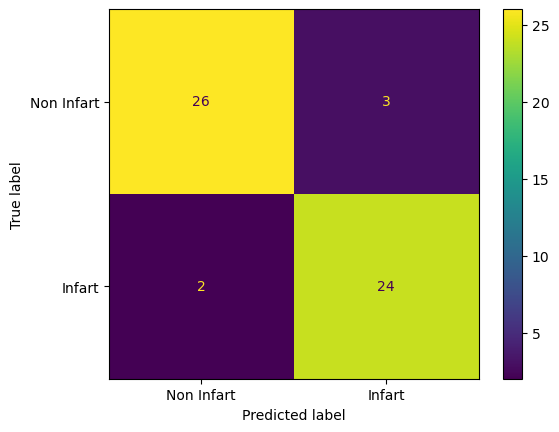

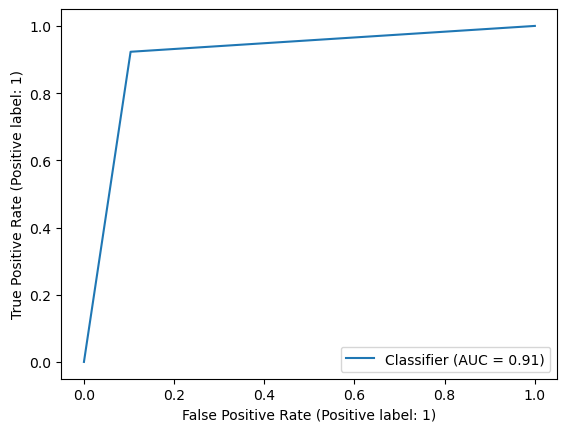

Estimator 1
Accuracy = 0.9272727272727272
Specificity = 1.0
Sensibility = 0.8461538461538461
False Positive rate: 0.0


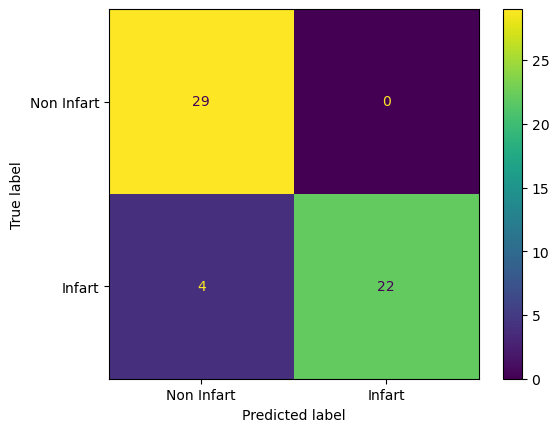

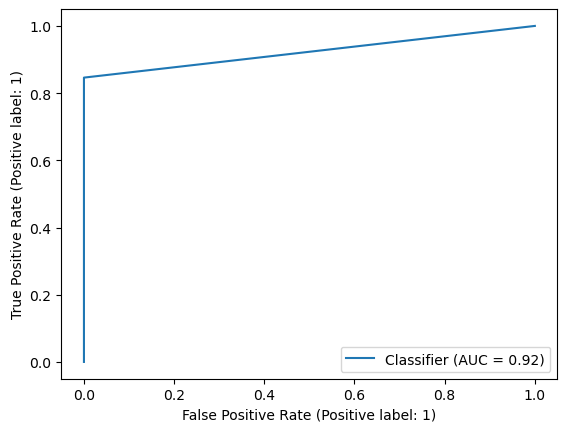

Estimator 2
Accuracy = 0.8909090909090909
Specificity = 1.0
Sensibility = 0.7692307692307693
False Positive rate: 0.0


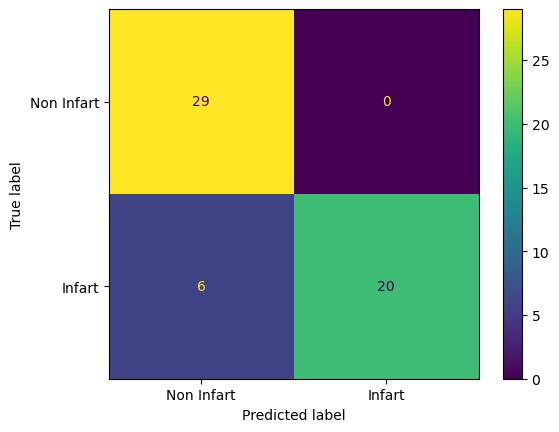

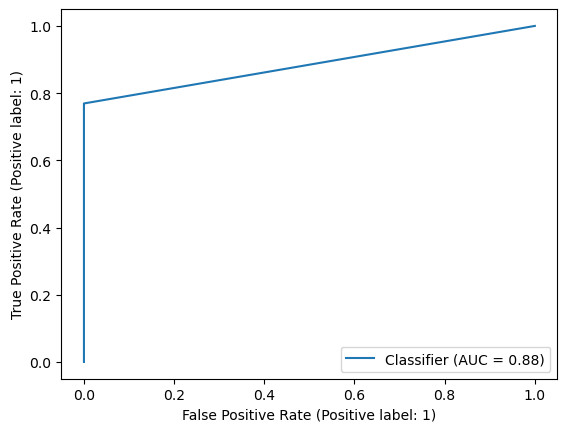

Estimator 3
Accuracy = 0.9272727272727272
Specificity = 0.9310344827586207
Sensibility = 0.9230769230769231
False Positive rate: 0.06896551724137934


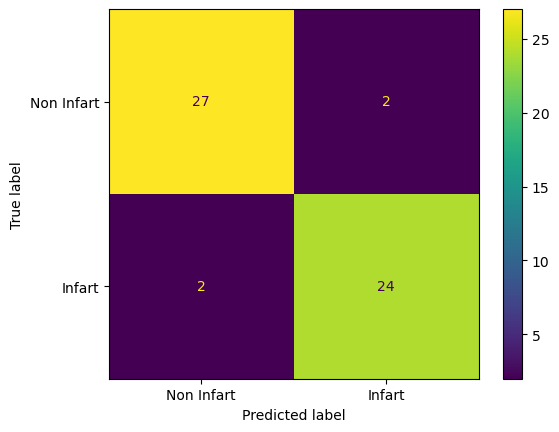

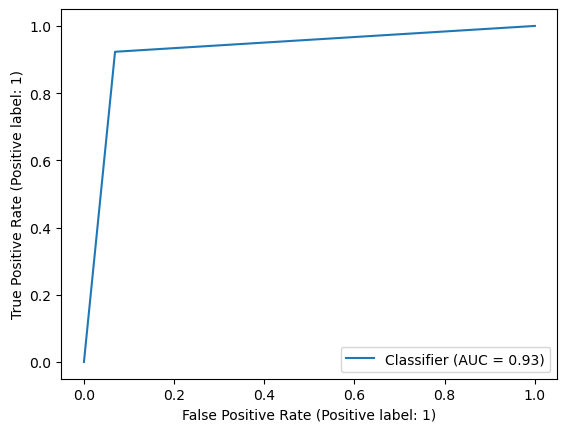

Estimator 4
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0


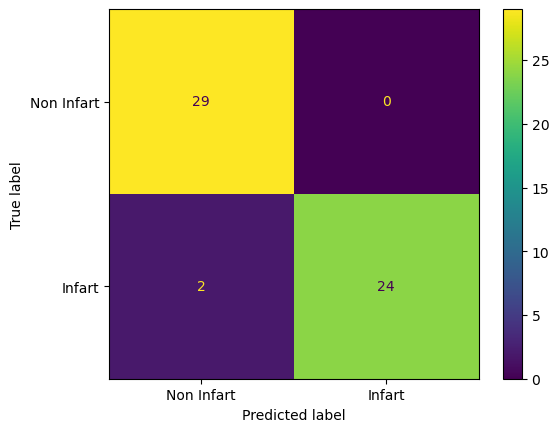

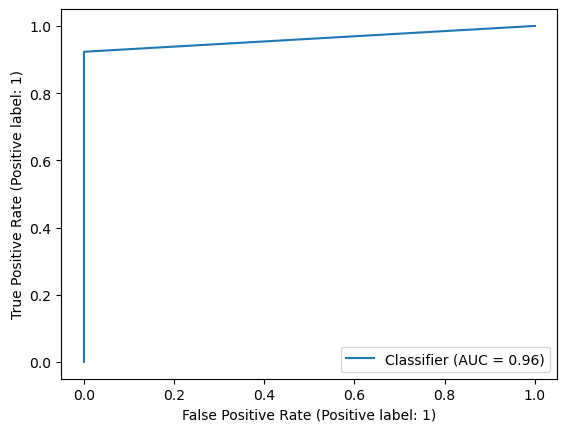

Estimator 5
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0


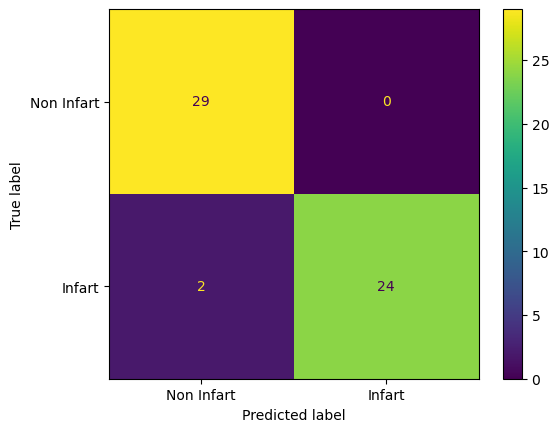

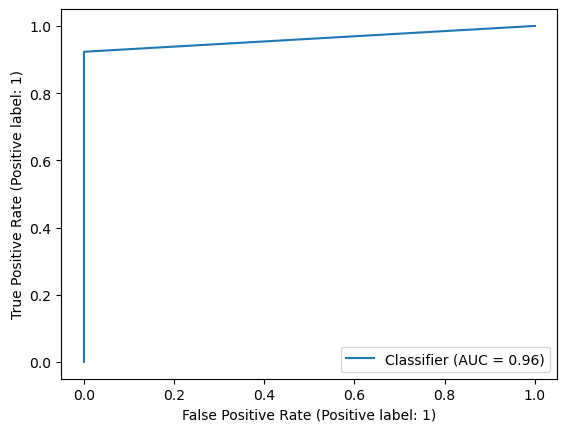

Estimator 6
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0


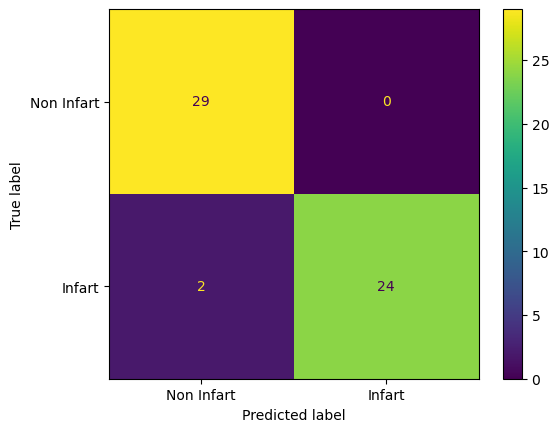

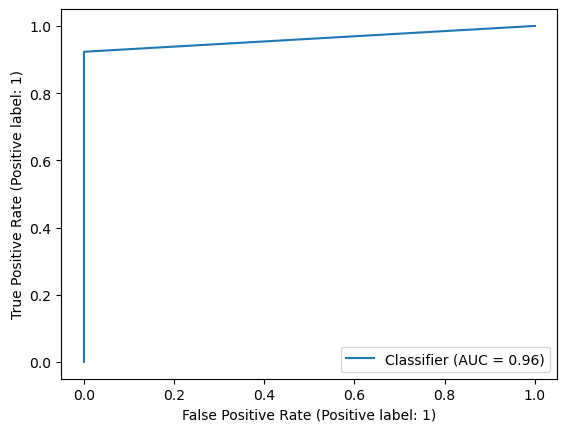

Estimator 7
Accuracy = 0.9272727272727272
Specificity = 1.0
Sensibility = 0.8461538461538461
False Positive rate: 0.0


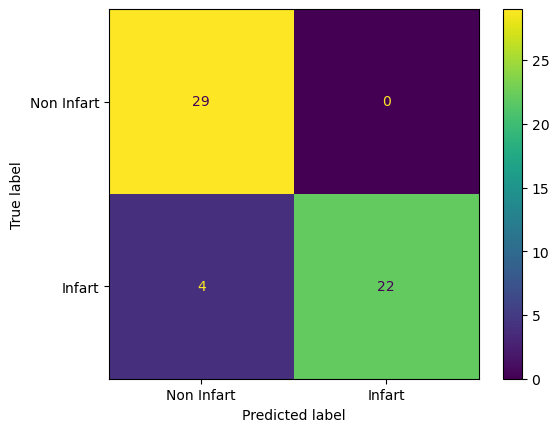

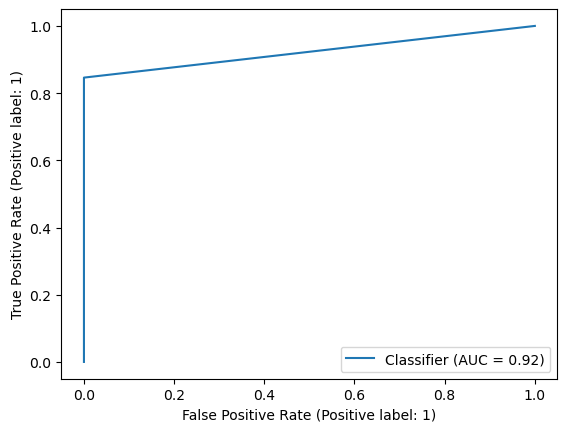

Estimator 8
Accuracy = 0.9636363636363636
Specificity = 0.9655172413793104
Sensibility = 0.9615384615384616
False Positive rate: 0.03448275862068961


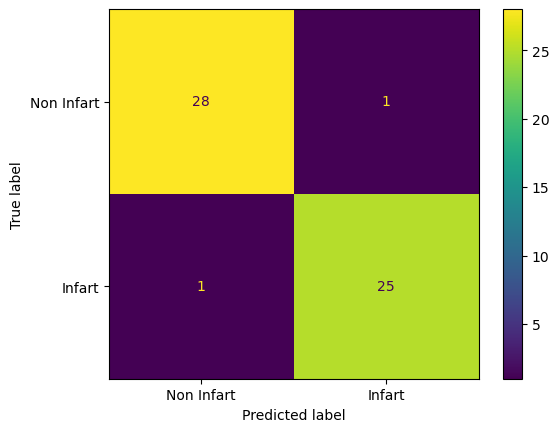

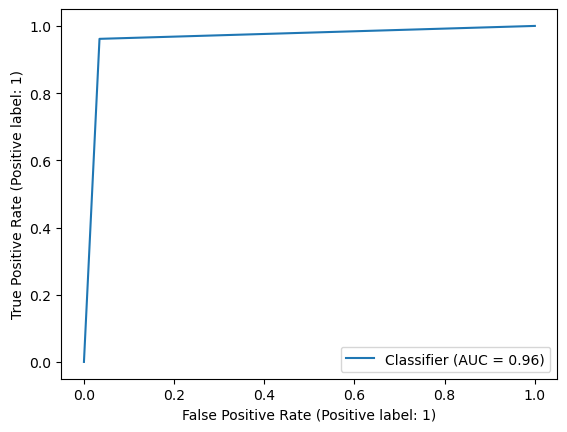

Estimator 9
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0


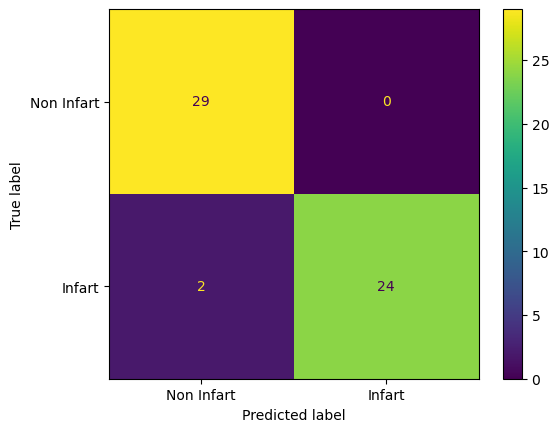

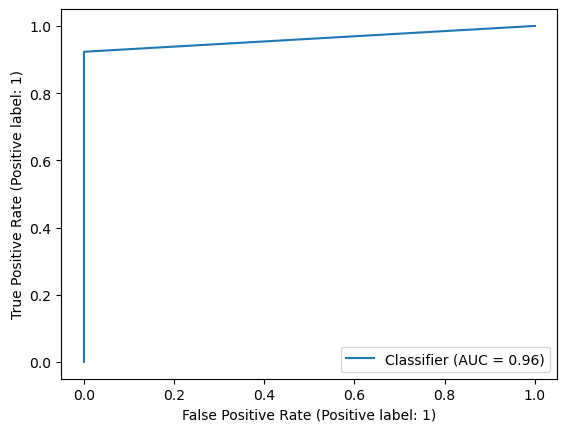

Mean Specificity= 0.9793103448275862 Std: 0.035165651817881276
Intervalo de confiança p < 0.95 0.8997601136853103 < x < 1.0
Mean Sensibility= 0.8961538461538462  Std: 0.05452864184137626
Intervalo de confiança p < 0.95 0.7728014884378387 < x < 1.0
Mean Accuracy = 0.9399999999999998 Sdt: 0.025777176143196055
Intervalo de confiança p < 0.95 0.8816879763524327 < x < 0.998312023647567
Mean False Positive Rate = 0.02068965517241379 Sdt: 0.03516565181788127
Intervalo de confiança p < 0.95 -0.05886057596986209 < x < 0.10023988631468968


In [118]:
model = DecisionTreeClassifier(random_state=seed)
model = gridSearch(model, param_grid_deci_tree, cv, x_train, y_train)
scores_tree = evaluate_model(model, x_train, y_train, cv)
best_tree = get_best_classifier(scores_tree)
estimators_tree = scores_tree['estimator']
(list_accuracy_tree, list_sensibility_tree, list_specificity_tree, list_false_positive_rate_tree) = evaluate_kfold(estimators_tree, X_total=x_total, y_total=y_total)

In [119]:
evaluate_estimator(best_tree, x_total, y_total)

----------------------------------------
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0
----------------------------------------


In [120]:
evaluate_estimator(best_tree, x_test, y_test)

----------------------------------------
Accuracy = 0.8823529411764706
Specificity = 1.0
Sensibility = 0.75
False Positive rate: 0.0
----------------------------------------


In [121]:
pred = marjoritary_vote(estimators_tree, x_total)
#print(pred)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0
----------------------------------------


In [122]:
best_tree.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

## Support Vector Machine

Best Params
{'C': 10.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
Estimator 0
Accuracy = 0.8727272727272727
Specificity = 0.8620689655172413
Sensibility = 0.8846153846153846
False Positive rate: 0.13793103448275867


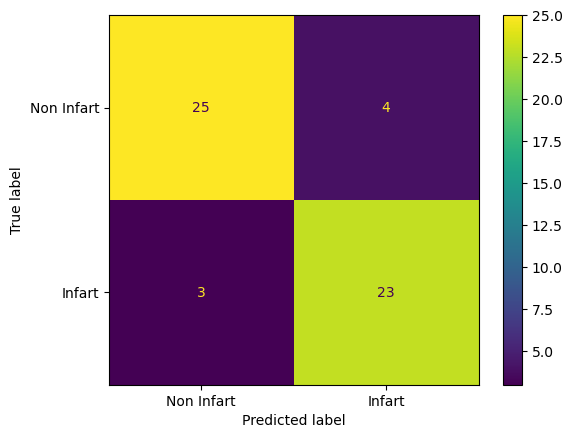

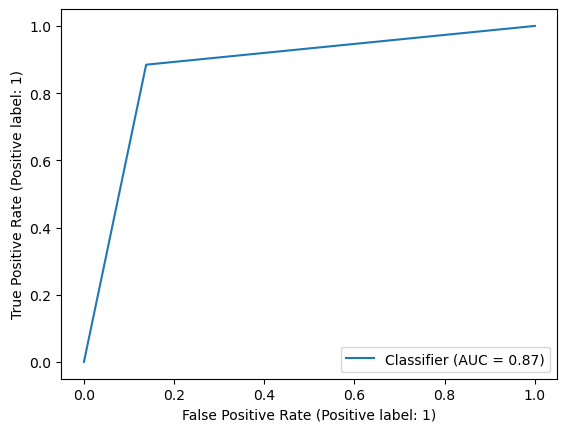

Estimator 1
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


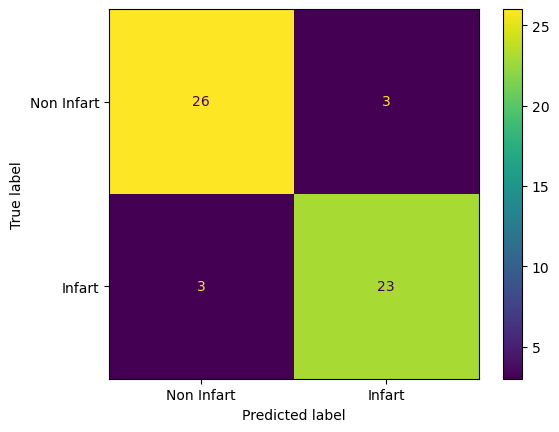

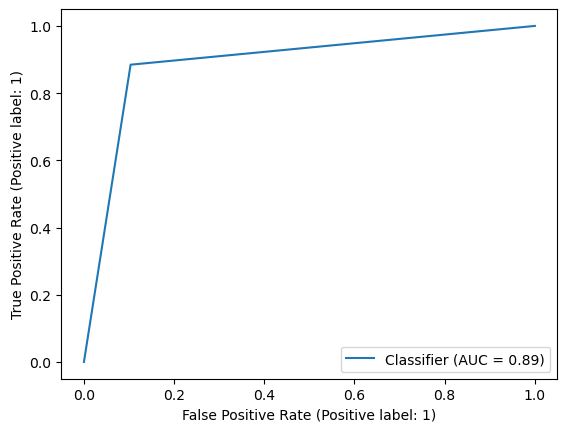

Estimator 2
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


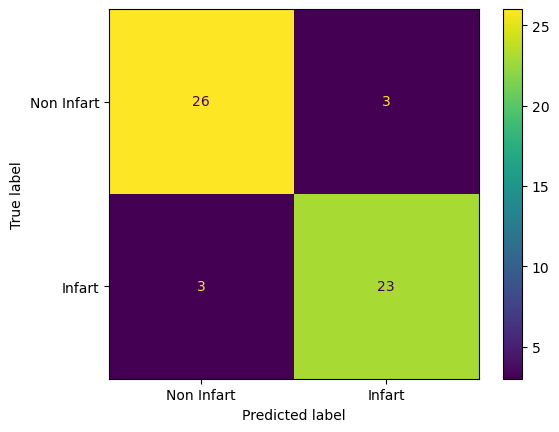

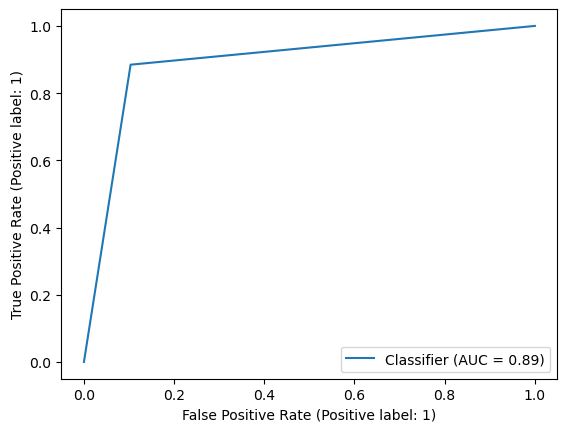

Estimator 3
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


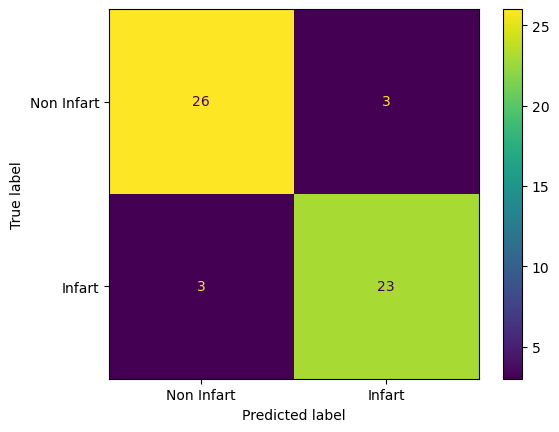

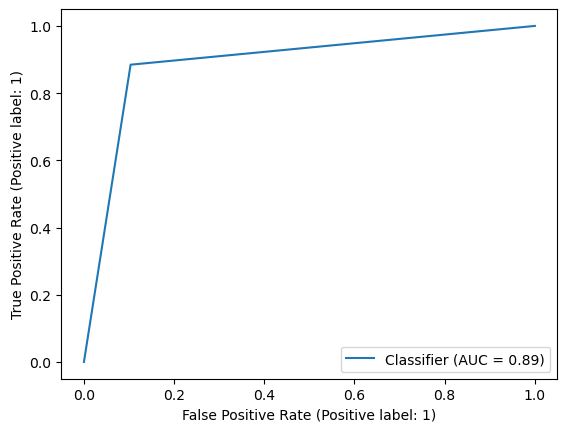

Estimator 4
Accuracy = 0.8727272727272727
Specificity = 0.8620689655172413
Sensibility = 0.8846153846153846
False Positive rate: 0.13793103448275867


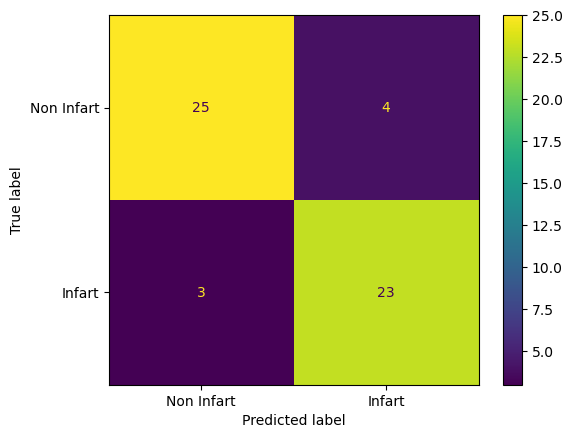

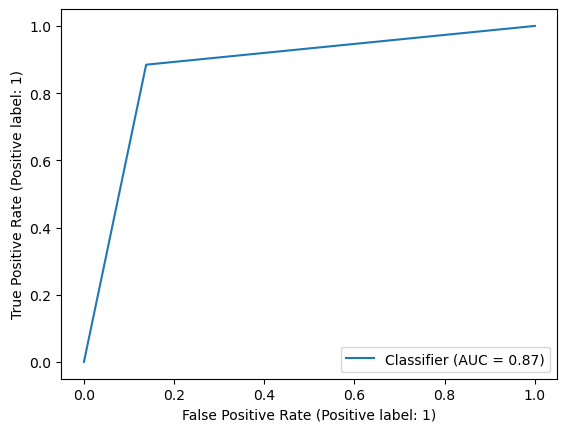

Estimator 5
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


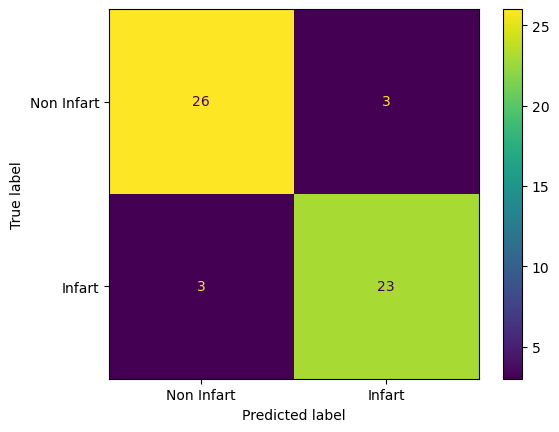

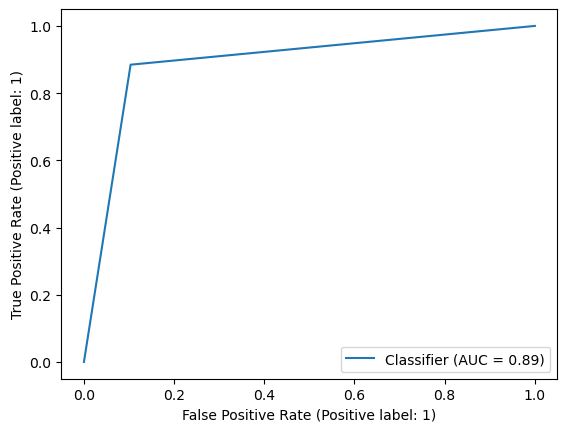

Estimator 6
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


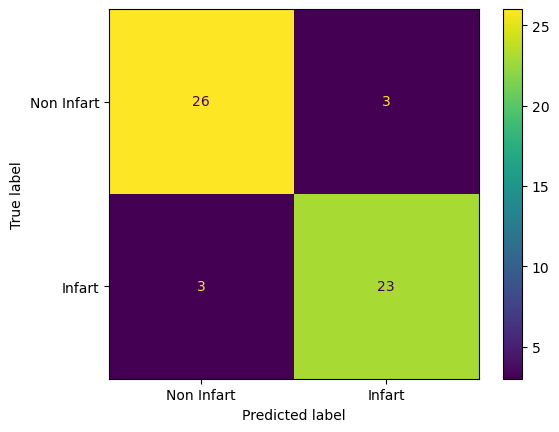

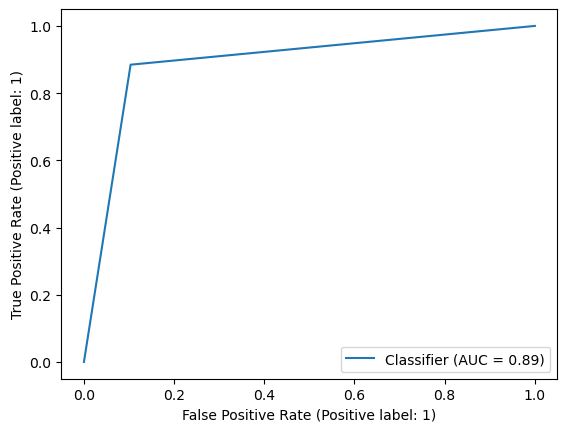

Estimator 7
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


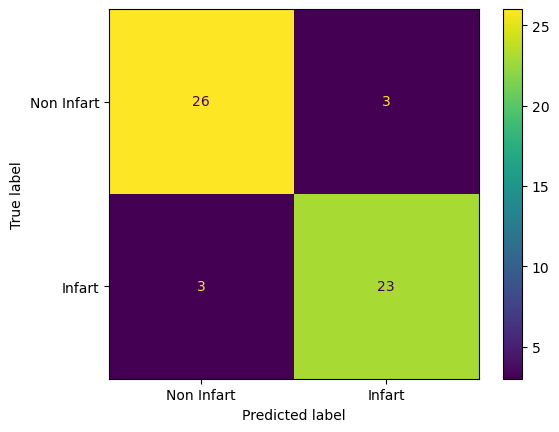

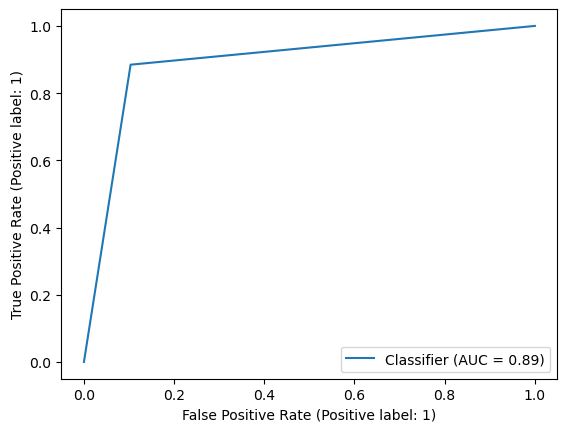

Estimator 8
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


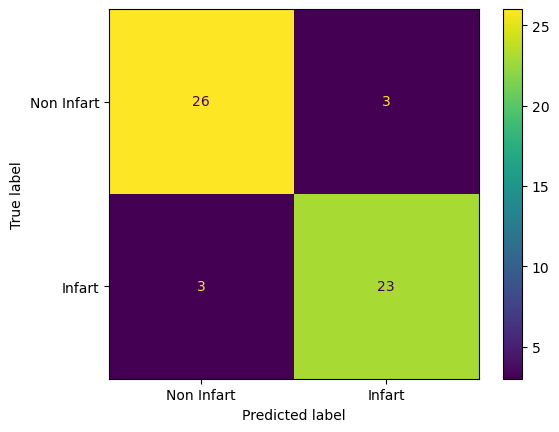

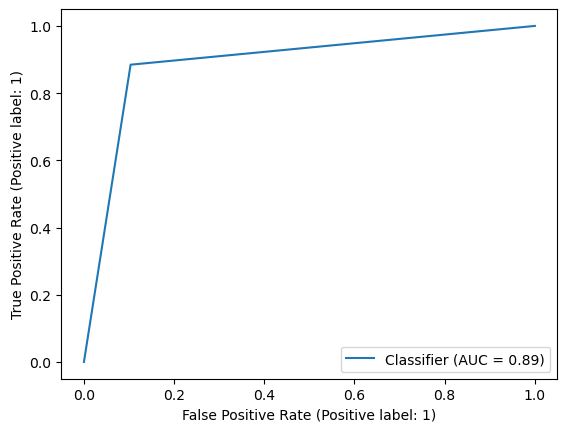

Estimator 9
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


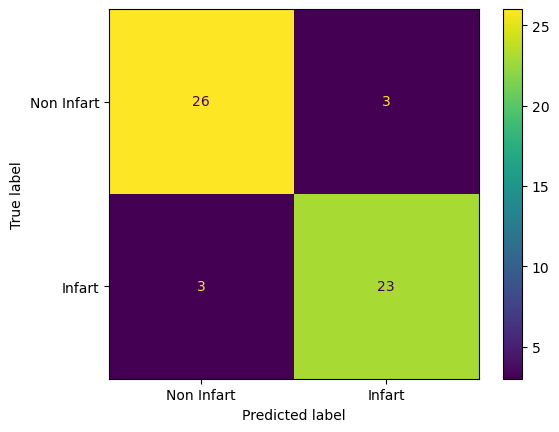

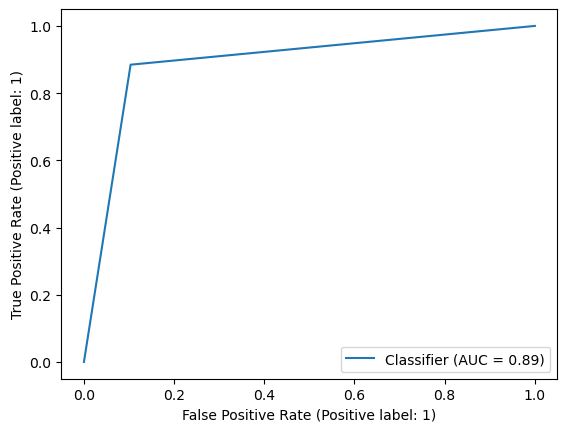

Mean Specificity= 0.8896551724137931 Std: 0.013793103448275888
Intervalo de confiança p < 0.95 0.8584530046518484 < x < 0.9208573401757378
Mean Sensibility= 0.8846153846153847  Std: 1.1102230246251565e-16
Intervalo de confiança p < 0.95 0.8846153846153845 < x < 0.8846153846153849
Mean Accuracy = 0.8872727272727273 Sdt: 0.007272727272727276
Intervalo de confiança p < 0.95 0.8708206751800656 < x < 0.9037247793653891
Mean False Positive Rate = 0.1103448275862069 Sdt: 0.013793103448275888
Intervalo de confiança p < 0.95 0.07914265982426212 < x < 0.14154699534815166


In [123]:
model = SVC(random_state=seed, probability=True)
model = gridSearch(model, param_grid_svm, cv, x_train, y_train)
scores_svm = evaluate_model(model, x_train, y_train, cv)
estimators_svm = scores_svm['estimator']
best_svm = get_best_classifier(scores_svm)
(list_accuracy_svc, list_sensibility_svc, list_specificity_svc, list_false_positive_rate_svc) = evaluate_kfold(estimators_svm, X_total=x_total, y_total=y_total)

In [124]:
evaluate_estimator(best_svm, x_total, y_total)

----------------------------------------
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895
----------------------------------------


In [125]:
evaluate_estimator(best_svm, x_test, y_test)

----------------------------------------
Accuracy = 0.8823529411764706
Specificity = 1.0
Sensibility = 0.75
False Positive rate: 0.0
----------------------------------------


In [126]:
pred = marjoritary_vote(estimators_svm, x_total)
#print(pred)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895
----------------------------------------


In [127]:
best_svm.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

## Random Forest

Best Params
{'criterion': 'gini', 'n_estimators': 100}
Estimator 0
Accuracy = 0.8727272727272727
Specificity = 0.8620689655172413
Sensibility = 0.8846153846153846
False Positive rate: 0.13793103448275867


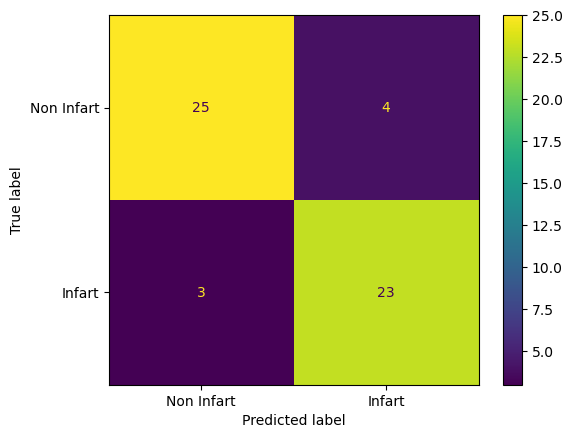

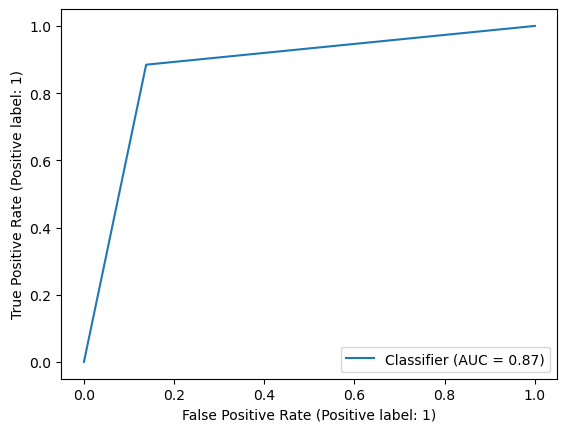

Estimator 1
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


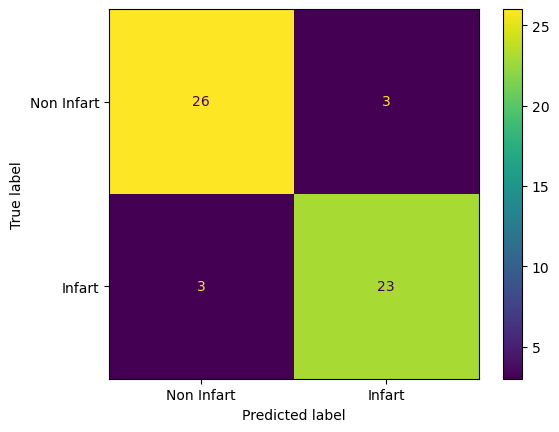

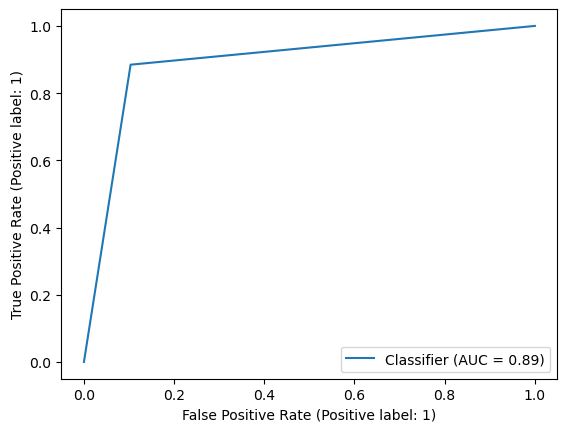

Estimator 2
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


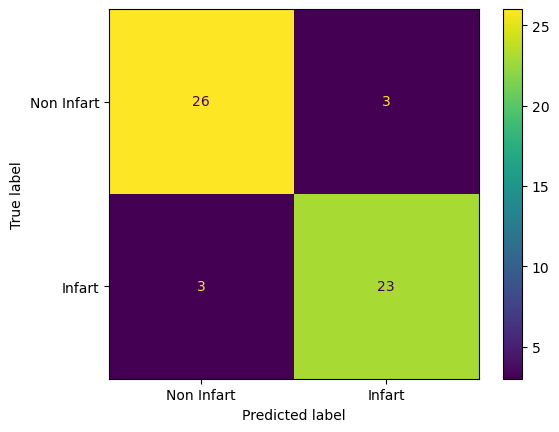

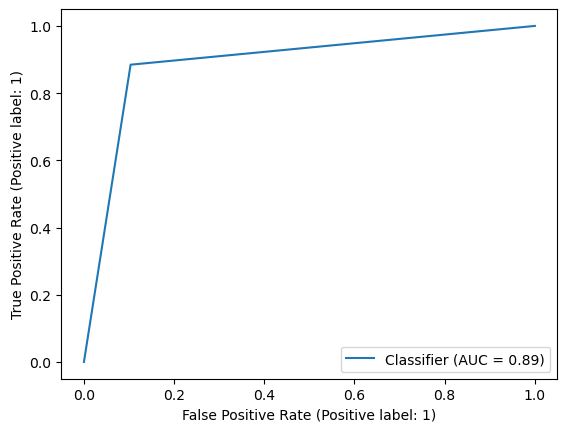

Estimator 3
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


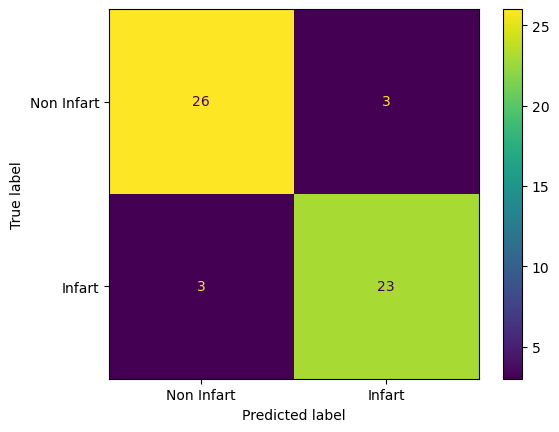

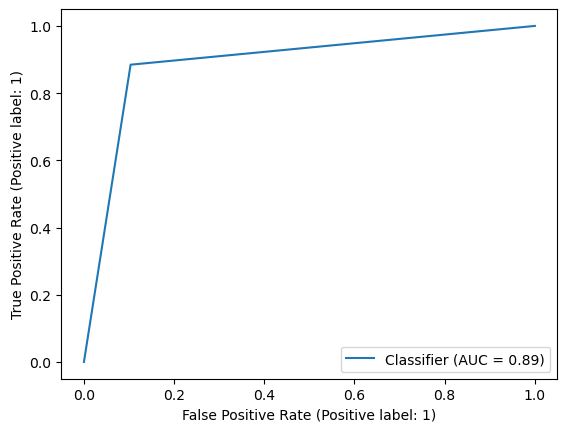

Estimator 4
Accuracy = 0.8727272727272727
Specificity = 0.8620689655172413
Sensibility = 0.8846153846153846
False Positive rate: 0.13793103448275867


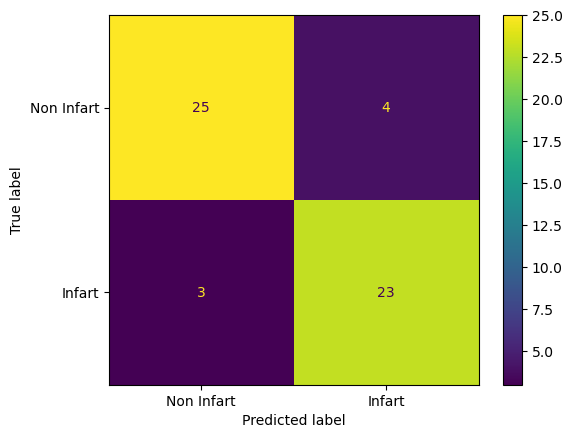

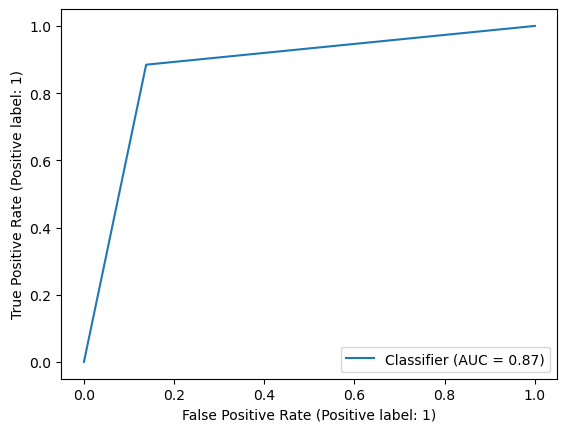

Estimator 5
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


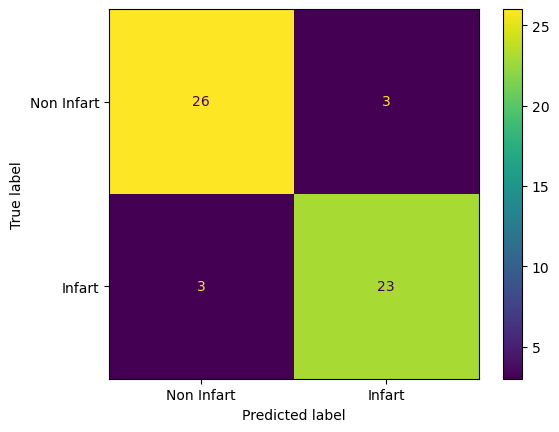

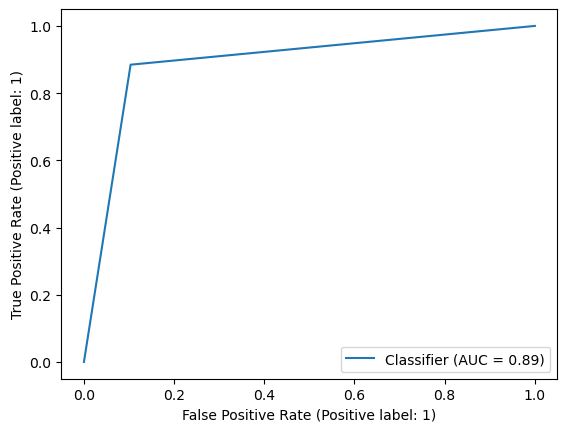

Estimator 6
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


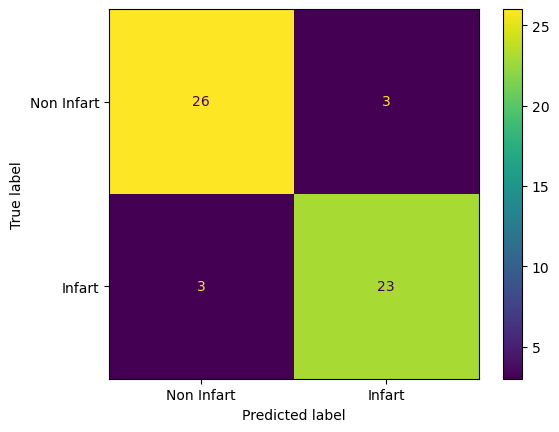

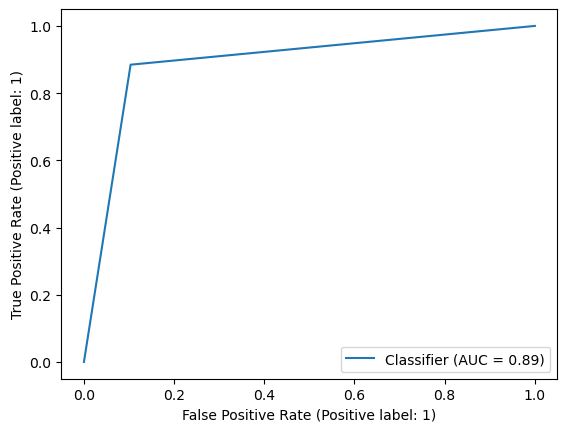

Estimator 7
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


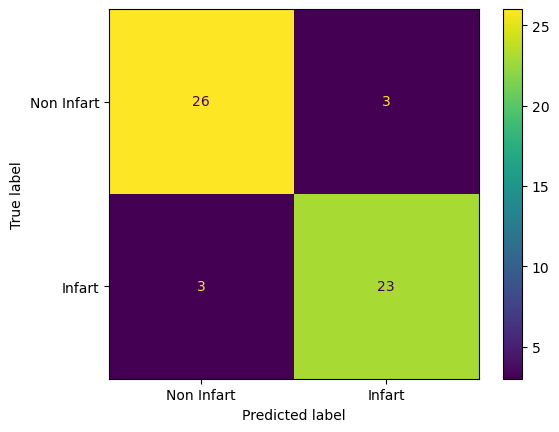

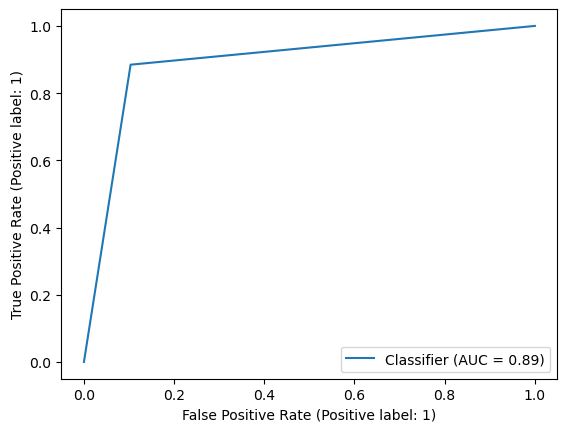

Estimator 8
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


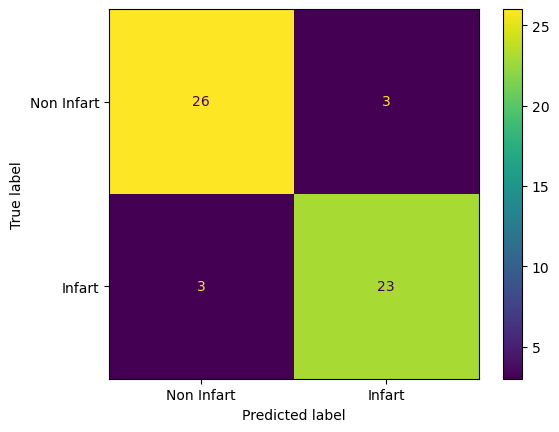

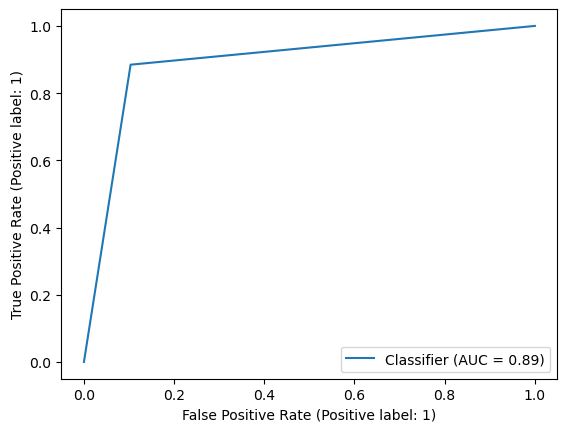

Estimator 9
Accuracy = 0.8909090909090909
Specificity = 0.896551724137931
Sensibility = 0.8846153846153846
False Positive rate: 0.10344827586206895


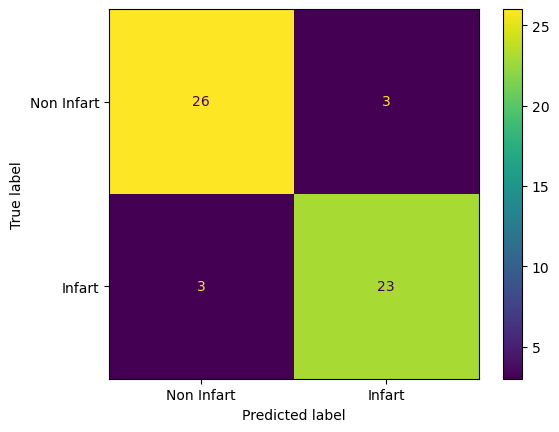

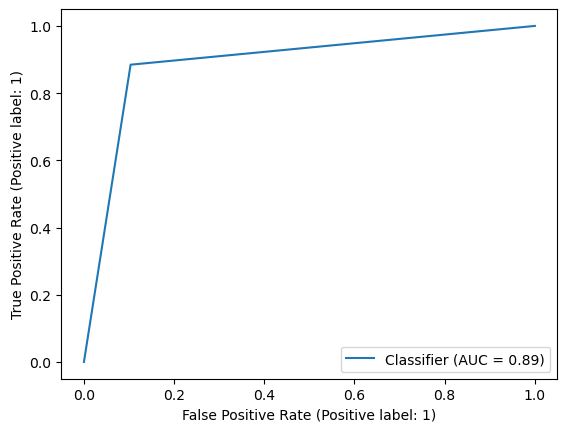

Mean Specificity= 0.8896551724137931 Std: 0.013793103448275888
Intervalo de confiança p < 0.95 0.8584530046518484 < x < 0.9208573401757378
Mean Sensibility= 0.8846153846153847  Std: 1.1102230246251565e-16
Intervalo de confiança p < 0.95 0.8846153846153845 < x < 0.8846153846153849
Mean Accuracy = 0.8872727272727273 Sdt: 0.007272727272727276
Intervalo de confiança p < 0.95 0.8708206751800656 < x < 0.9037247793653891
Mean False Positive Rate = 0.1103448275862069 Sdt: 0.013793103448275888
Intervalo de confiança p < 0.95 0.07914265982426212 < x < 0.14154699534815166


In [128]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=seed)
model = gridSearch(model, param_grid_random_forest, cv, x_train, y_train)
scores_rf = evaluate_model(model, x_train, y_train, cv)
estimators_rf = scores_rf['estimator']
best_rf = get_best_classifier(scores_rf)
(list_accuracy_rf, list_sensibility_rf, list_specificity_rf, list_false_positive_rate_rf) = evaluate_kfold(estimators_svm, X_total=x_total, y_total=y_total)

In [129]:
evaluate_estimator(best_rf, x_total, y_total)

----------------------------------------
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0
----------------------------------------


In [130]:
evaluate_estimator(best_rf, x_test, y_test)

----------------------------------------
Accuracy = 0.8823529411764706
Specificity = 1.0
Sensibility = 0.75
False Positive rate: 0.0
----------------------------------------


In [131]:
best_rf.predict(x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# Implementando uma MLP

In [132]:
param_grid_mlp = {
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.1, 1.0], 
}

Best Params
{'activation': 'relu', 'alpha': 0.001, 'solver': 'lbfgs'}
Estimator 0
Accuracy = 0.9636363636363636
Specificity = 0.9655172413793104
Sensibility = 0.9615384615384616
False Positive rate: 0.03448275862068961


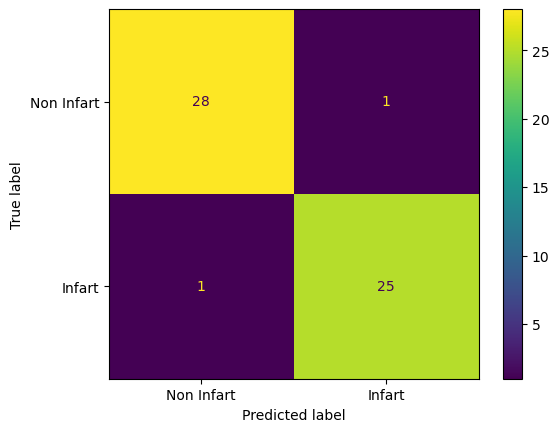

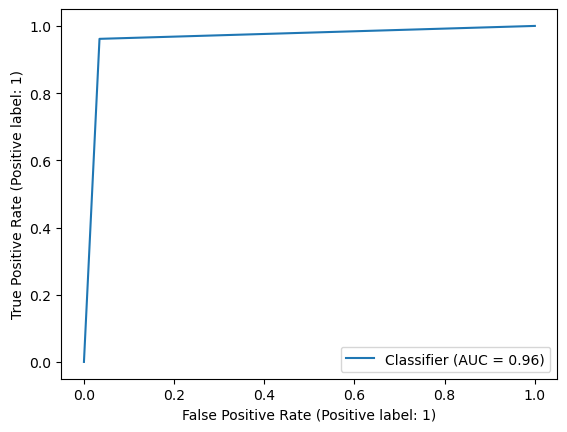

Estimator 1
Accuracy = 0.9818181818181818
Specificity = 1.0
Sensibility = 0.9615384615384616
False Positive rate: 0.0


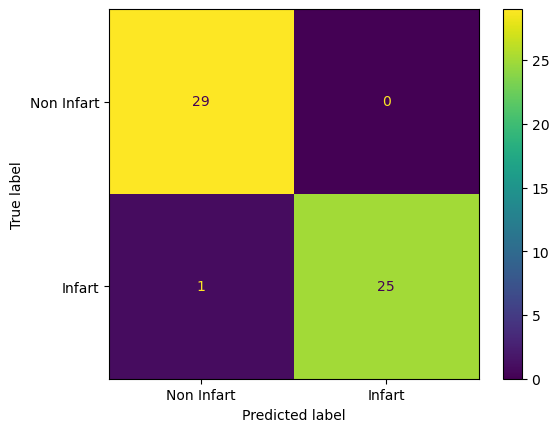

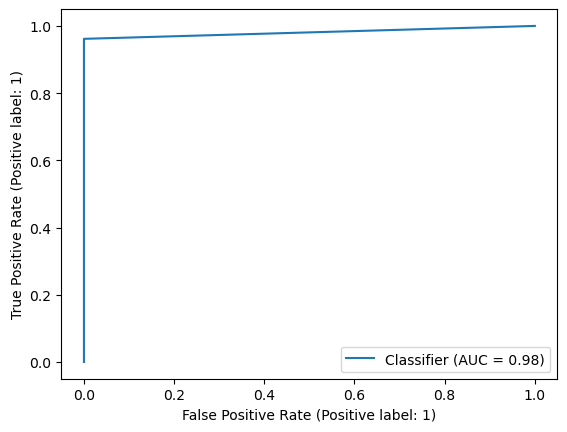

Estimator 2
Accuracy = 0.9818181818181818
Specificity = 1.0
Sensibility = 0.9615384615384616
False Positive rate: 0.0


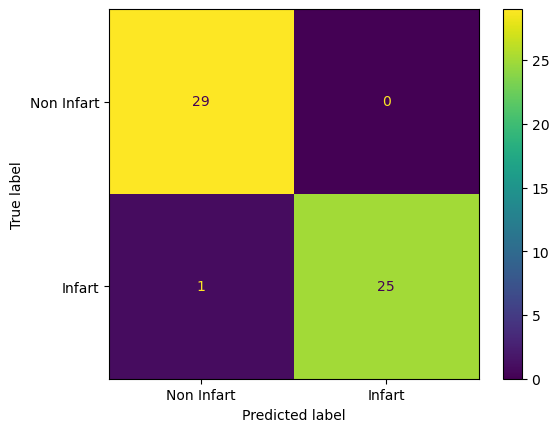

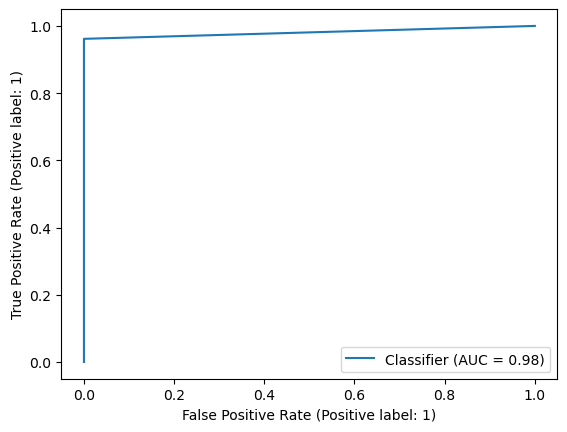

Estimator 3
Accuracy = 0.9454545454545454
Specificity = 1.0
Sensibility = 0.8846153846153846
False Positive rate: 0.0


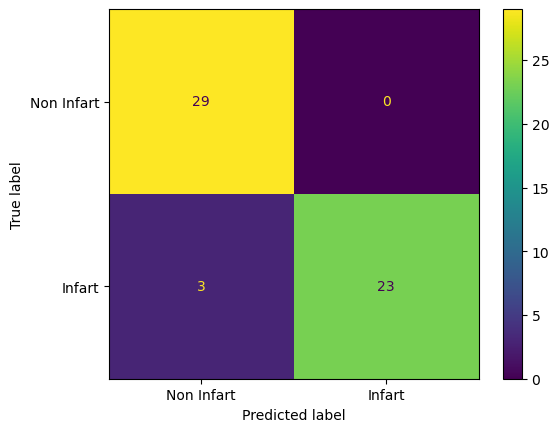

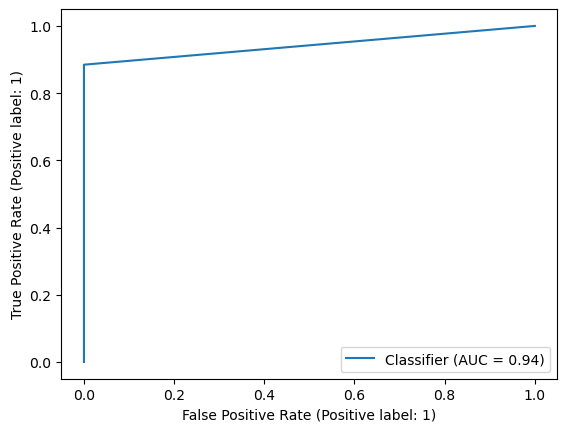

Estimator 4
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0


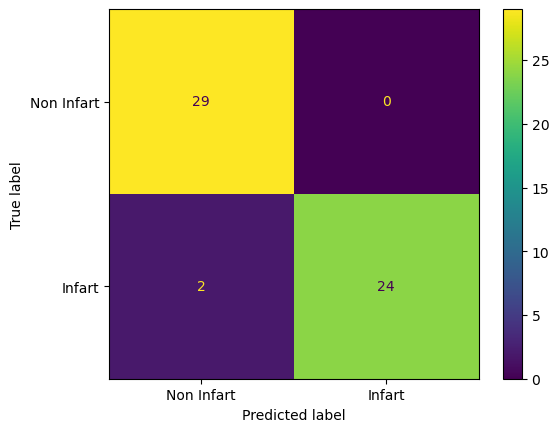

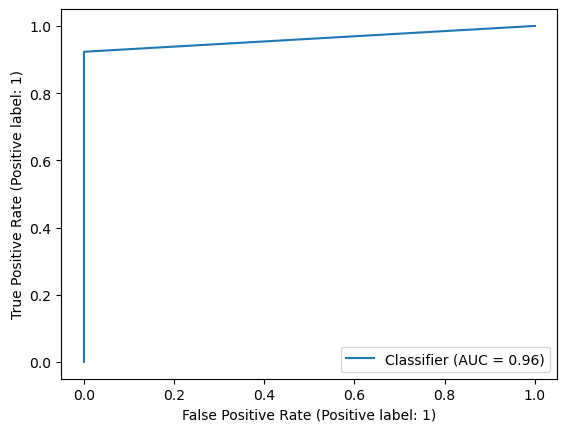

Estimator 5
Accuracy = 0.9818181818181818
Specificity = 1.0
Sensibility = 0.9615384615384616
False Positive rate: 0.0


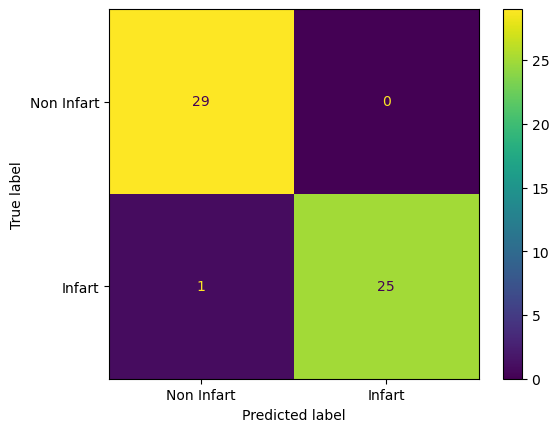

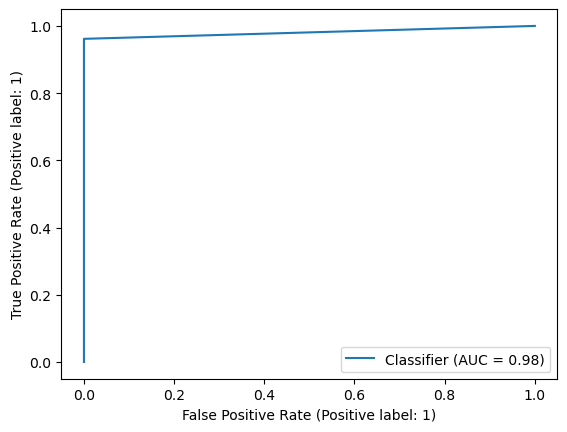

Estimator 6
Accuracy = 0.9818181818181818
Specificity = 1.0
Sensibility = 0.9615384615384616
False Positive rate: 0.0


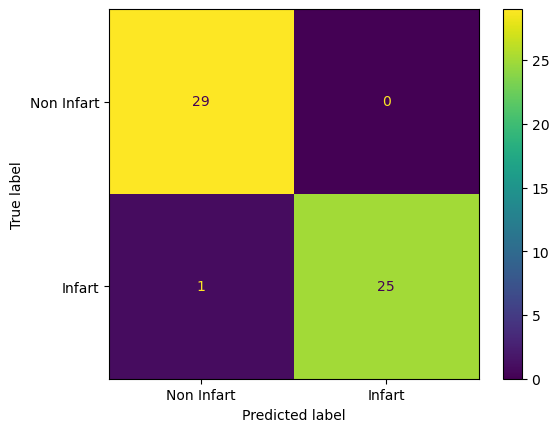

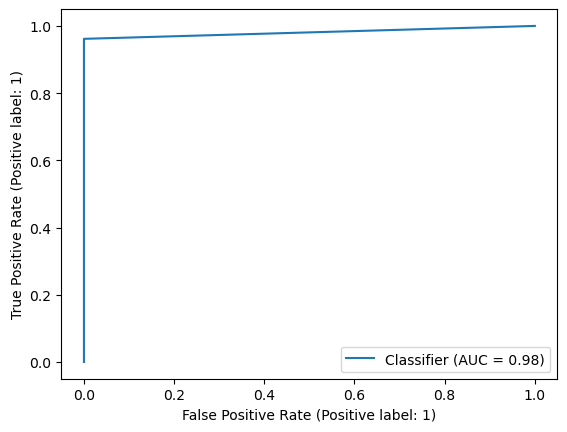

Estimator 7
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0


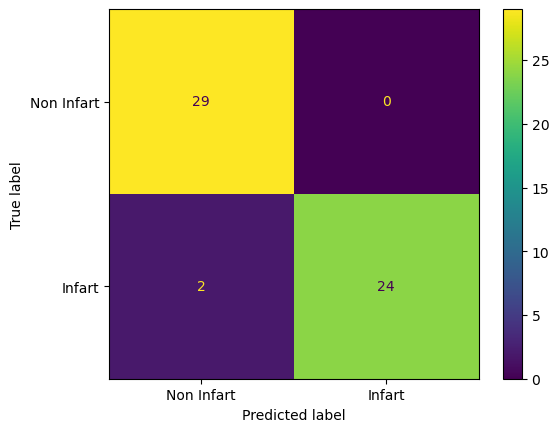

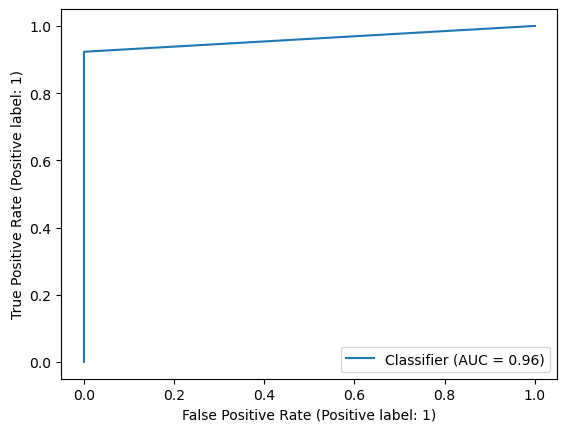

Estimator 8
Accuracy = 0.9818181818181818
Specificity = 1.0
Sensibility = 0.9615384615384616
False Positive rate: 0.0


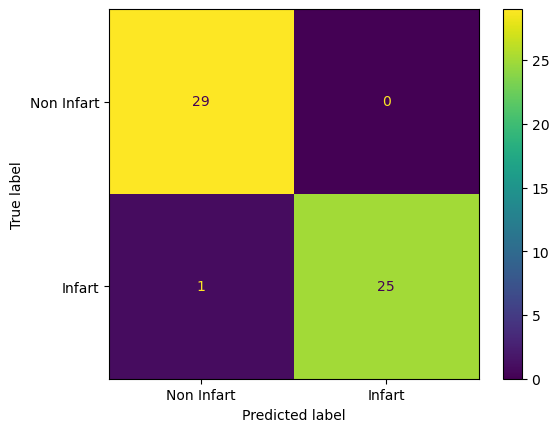

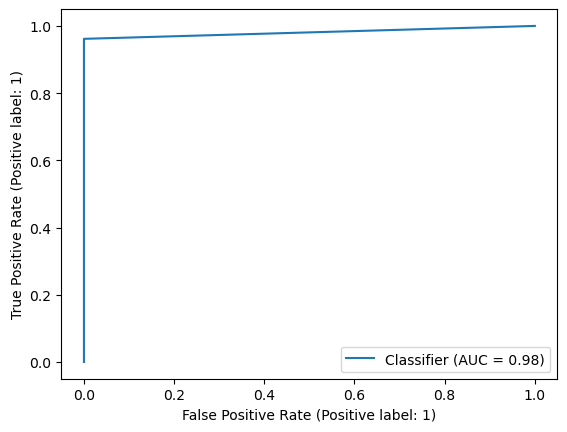

Estimator 9
Accuracy = 0.9636363636363636
Specificity = 1.0
Sensibility = 0.9230769230769231
False Positive rate: 0.0


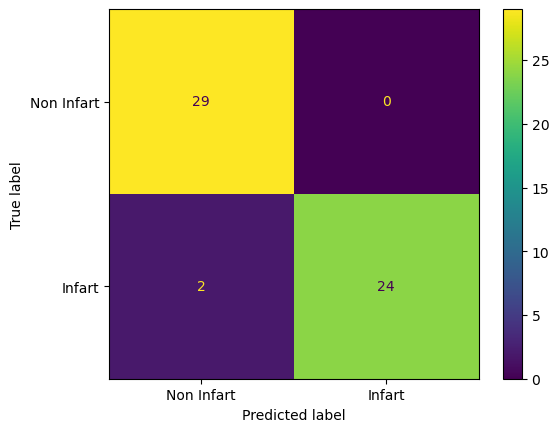

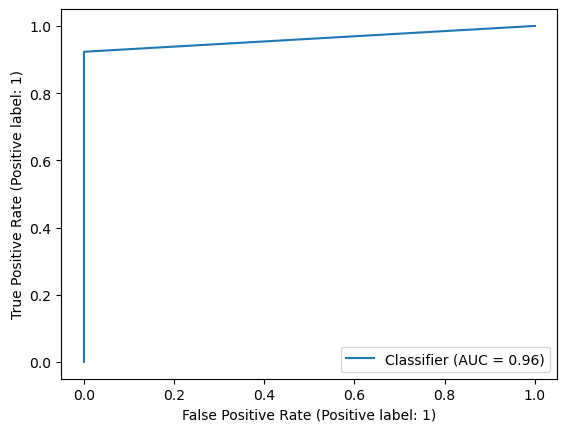

Mean Specificity= 0.9965517241379309 Std: 0.010344827586206884
Intervalo de confiança p < 0.95 0.9731500983164724 < x < 1.0
Mean Sensibility= 0.9423076923076923  Std: 0.025800784355766812
Intervalo de confiança p < 0.95 0.8839422631729587 < x < 1.0
Mean Accuracy = 0.9709090909090909 Sdt: 0.012060453783110549
Intervalo de confiança p < 0.95 0.9436264489977207 < x < 0.9981917328204611
Mean False Positive Rate = 0.003448275862068961 Sdt: 0.010344827586206884
Intervalo de confiança p < 0.95 -0.019953349959389542 < x < 0.026849901683527466


In [133]:
mlp = MLPClassifier(random_state=seed, max_iter=10000, verbose=False)
mlp = gridSearch(mlp, param_grid_mlp, cv, x_train, y_train)
scores_mlp = evaluate_model(mlp, x_train, y_train, cv)
estimators_mlp = scores_mlp['estimator']
best_mlp = get_best_classifier(scores_mlp)
(list_accuracy_mlp, list_sensibility_mlp, list_specificity_mlp, list_false_positive_rate_mlp) = evaluate_kfold(estimators_mlp, X_total=x_total, y_total=y_total)

In [137]:
evaluate_estimator(best_mlp, x_test, y_test)

----------------------------------------
Accuracy = 0.9411764705882353
Specificity = 1.0
Sensibility = 0.875
False Positive rate: 0.0
----------------------------------------


In [138]:
evaluate_estimator(best_mlp, x_total, y_total)

----------------------------------------
Accuracy = 0.9818181818181818
Specificity = 1.0
Sensibility = 0.9615384615384616
False Positive rate: 0.0
----------------------------------------


In [139]:
best_mlp.predict(x_sanity)

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

# Implementando o voto majoritário dos classificadores
Implementando o voto majoritário entre Regressão Logística, Árvore de Decisão e random forest, svm e knn

In [75]:
pred = marjoritary_vote([logistic_best, best_mlp, best_svm, best_tree, knn_best], x_total)
print_metrics(y_total, pred)

----------------------------------------
Accuracy = 0.9090909090909091
Specificity = 0.9310344827586207
Sensibility = 0.8846153846153846
False Positive rate: 0.06896551724137934
----------------------------------------


In [76]:
pred = marjoritary_vote([logistic_best, best_mlp, best_svm, best_tree, knn_best], x_test)
print_metrics(y_test, pred)

----------------------------------------
Accuracy = 0.8823529411764706
Specificity = 1.0
Sensibility = 0.75
False Positive rate: 0.0
----------------------------------------


In [77]:
marjoritary_vote([logistic_best, best_mlp, best_svm, best_tree, knn_best], x_sanity)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Aplicando os testes estatísticos Friedman e Nemenyi

A primeira coisa que temos que fazer é verificar se cada uma dessas medidas apresentam uma distribuição normal através do teste de Shapiro-Wilker
Se a distribuição é Normal, aplica o teste ANOVA
Se a distribuição não é Normal aplica o teste de Friedman

In [65]:
accuracy_measures = np.array([list_accuracy_logistic,
                              list_accuracy_knn,
                              list_accuracy_mlp,
                              list_accuracy_rf,
                              list_accuracy_svc,
                              list_accuracy_tree])

sensibility_measures = np.array([list_sensibility_logistic,
                              list_sensibility_knn,
                              list_sensibility_mlp,
                              list_sensibility_rf,
                              list_sensibility_svc,
                              list_sensibility_tree])

specificity_measures = np.array([list_specificity_logistic,
                              list_specificity_knn,
                              list_specificity_mlp,
                              list_specificity_rf,
                              list_specificity_svc,
                              list_specificity_tree])

false_p_measures = np.array([list_false_positive_rate_logistic,
                              list_false_positive_rate_knn,
                              list_false_positive_rate_mlp,
                              list_false_positive_rate_rf,
                              list_false_positive_rate_svc,
                              list_false_positive_rate_tree])

In [71]:
columns_classifiers = ["reg_logistic", "knn", "mlp", "random_for", "svm", "deci_tree"]
pd.DataFrame(accuracy_measures.T, columns=columns_classifiers).to_csv("../data/results/accuracy_measures.csv")
pd.DataFrame(sensibility_measures.T, columns=columns_classifiers).to_csv("../data/results/sensibility_measures.csv")
pd.DataFrame(specificity_measures.T, columns=columns_classifiers).to_csv("../data/results/specificity_measures.csv")
pd.DataFrame(false_p_measures.T, columns=columns_classifiers).to_csv("../data/results/false_positive_rate_measures.csv")

In [203]:
# Aplicando o teste de Shapiro-Wilk para determinar a normalidade dos dados
print("Accuracy Test")
print("**********************************\n")
for i in range(accuracy_measures.shape[1]):
    stats_, p = stats.shapiro(accuracy_measures[:,i])
    print(stats_, p)
    
# Aplicando o teste de Shapiro-Wilk para determinar a normalidade dos dados
print("Sensibility")
print("**********************************\n")
for i in range(sensibility_measures.shape[1]):
    stats_, p = stats.shapiro(sensibility_measures[:,i])
    print(stats_, p)
    
# Aplicando o teste de Shapiro-Wilk para determinar a normalidade dos dados
print("Specificity")
print("**********************************\n")
for i in range(specificity_measures.shape[1]):
    stats_, p = stats.shapiro(specificity_measures[:,i])
    print(stats_, p)
    
# Aplicando o teste de Shapiro-Wilk para determinar a normalidade dos dados
print("False Positive rate")
print("**********************************\n")
for i in range(false_p_measures.shape[1]):
    stats_, p = stats.shapiro(false_p_measures[:, i])
    print(stats_, p)

Accuracy Test
**********************************

0.9554956555366516 0.7844412922859192
0.9693095684051514 0.887765109539032
0.8447369337081909 0.14262135326862335
0.9674304723739624 0.8747507929801941
0.8432961702346802 0.13879111409187317
0.9343457221984863 0.6140544414520264
0.9153215885162354 0.47232016921043396
0.9731918573379517 0.9131487011909485
0.9153215885162354 0.47232016921043396
0.8863087892532349 0.2992970049381256
Sensibility
**********************************

0.9154587984085083 0.47326990962028503
0.924091637134552 0.5353068113327026
0.9552926421165466 0.7828269004821777
0.7968915104866028 0.0550985150039196
0.8148744106292725 0.07964175939559937
0.8686814308166504 0.2209995836019516
0.9154587984085083 0.47326990962028503
0.8658724427223206 0.21024195849895477
0.8895167708396912 0.3156636357307434
0.8148744106292725 0.07964175939559937
Specificity
**********************************

0.7727189064025879 0.03293723240494728
0.6398937702178955 0.0013507552212104201
0.75467

O teste de Shapiro-Wilk revelou que não dá para descartar a normal com relação a acurácia e sensibilidade
O teste também revelou que dá para descartar a normal com relação a specificidade e taxa de falsos positivos


Text(0.5, 0, '1 - Specificity')

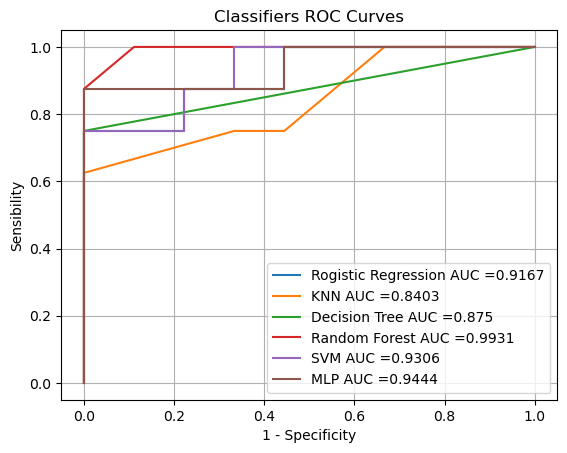

In [75]:
# Observando os classificadores com relação a curva ROC
array_classifiers = [logistic_best, knn_best, best_tree, best_rf, best_svm, best_mlp]
array_names = ["Rogistic Regression", "KNN", "Decision Tree", "Random Forest", "SVM", "MLP"]

for i, cls in enumerate(array_classifiers):
    pred_y = cls.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, pred_y)
    auc = round(metrics.roc_auc_score(y_test, pred_y), 4)
    plt.plot(fpr, tpr, label="" + array_names[i] + " AUC =" + str(auc))

plt.legend()
plt.title("Classifiers ROC Curves")
plt.ylabel("Sensibility")
plt.grid(True)
plt.xlabel("1 - Specificity")


Text(0.5, 0, '1 - Specificity')

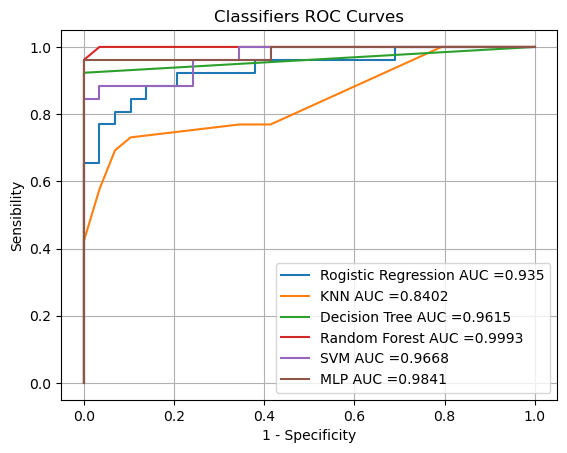

In [76]:
for i, cls in enumerate(array_classifiers):
    pred_y = cls.predict_proba(x_total)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_total, pred_y)
    auc = round(metrics.roc_auc_score(y_total, pred_y), 4)
    plt.plot(fpr, tpr, label="" + array_names[i] + " AUC =" + str(auc))

plt.legend()
plt.title("Classifiers ROC Curves")
plt.ylabel("Sensibility")
plt.grid(True)
plt.xlabel("1 - Specificity")